## Citi Bike NYC 2018

# Data Preparation

In [79]:
import os
import pandas as pd
from typing import Optional

pd.set_option('display.max_columns', None)

DATA_DIR = os.path.abspath('data')
RAW_TRIPS_PATH = os.path.join(DATA_DIR, 'Trips_2018.csv')
HOLIDAYS_PATH = os.path.join(DATA_DIR, 'holidays_2018_nyc.csv')
EVENTS_PATH = os.path.join(DATA_DIR, 'events_2018_nyc.csv')

RAW_TRIPS_PATH, HOLIDAYS_PATH, EVENTS_PATH


('/Users/estebanperez/Documents/progra/my-py-notebooks/project/data/Trips_2018.csv',
 '/Users/estebanperez/Documents/progra/my-py-notebooks/project/data/holidays_2018_nyc.csv',
 '/Users/estebanperez/Documents/progra/my-py-notebooks/project/data/events_2018_nyc.csv')

In [80]:
# Load holidays and events
holidays = pd.read_csv(HOLIDAYS_PATH, parse_dates=['date'])
# Normalize date to date only
holidays['date'] = holidays['date'].dt.normalize()

events = pd.read_csv(EVENTS_PATH, parse_dates=['start_datetime', 'end_datetime'])

print('Holidays:', holidays.shape)
print('Events:', events.shape)
holidays.head(2)


Holidays: (10, 5)
Events: (13, 6)


,name,date,region,category,notes
0,New Year's Day,2018-01-01,NYC,US Federal,NaN
1,Martin Luther King Jr. Day,2018-01-15,NYC,US Federal,NaN


In [81]:
events.head(2)

,name,start_datetime,end_datetime,borough,category,notes
0,St. Patrick's Day Parade,2018-03-17 11:00:00,2018-03-17 17:00:00,Manhattan,Parade,Fifth Ave corridor closures
1,TD Five Boro Bike Tour,2018-05-06 07:00:00,2018-05-06 17:00:00,Multiple,Sports,Citywide route impacts


### Load raw rides (chunked) and validate schema
We will stream the large CSV to avoid memory pressure. The loader:
- Infers likely Citi Bike column names and standardizes to a canonical schema
- Parses datetimes safely
- drops invalid rows and outliers
- Tracks basic QA metrics (missing rates, outlier rates)



In [82]:
CANONICAL_COLS = {
    "id": "id",
    "tripduration": "trip_duration_sec",
    "starttime": "start_time",
    "stoptime": "end_time",
    "start_station_id": "start_station_id",
    "start_station_latitude": "start_lat",
    "start_station_longitude": "start_lng",
    "end_station_id": "end_station_id",
    "end_station_latitude": "end_lat",
    "end_station_longitude": "end_lng",
    "bikeid": "bike_id",
    "usertype": "user_type",
    "birth_year": "birth_year",
    "gender": "gender",
}

CANONICAL_SET = set(CANONICAL_COLS.values())

DTYPES_BASE = {
    "trip_duration_sec": "float64",
    "start_station_id": "int",
    "end_station_id": "int",
    "bike_id": "string",
    "user_type": "string",
    "birth_year": "float64",
    "gender": "string",
    "start_lat": "float64",
    "start_lng": "float64",
    "end_lat": "float64",
    "end_lng": "float64",
}

CHUNKSIZE = 250_000


def _standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {}
    for col in df.columns:
        low = col.strip().lower()
        mapping[col] = CANONICAL_COLS[low]

    df = df.rename(columns=mapping)
    return df


def _parse_times(df: pd.DataFrame) -> pd.DataFrame:
    df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
    df["end_time"] = pd.to_datetime(df["end_time"], errors="coerce")
    return df


def _compute_duration_if_missing(df: pd.DataFrame) -> pd.DataFrame:
    if "trip_duration_sec" not in df.columns:
        df["trip_duration_sec"] = (df["end_time"] - df["start_time"]).dt.total_seconds()
    return df


def _filter_invalid(df: pd.DataFrame) -> pd.DataFrame:
    # Drop invalid times
    if {"start_time", "end_time"}.issubset(df.columns):
        df = df[df["start_time"].notna() & df["end_time"].notna()]
        df = df[df["end_time"] >= df["start_time"]]

        # Filter to only 2018 data (exclude trips starting or ending in 2019)
        df = df[df["start_time"].dt.year == 2018]
        df = df[df["end_time"].dt.year == 2018]

    # Duration sanity: 1 minute to 24 hours
    if "trip_duration_sec" in df.columns:
        df = df[
            (df["trip_duration_sec"] >= 60) & (df["trip_duration_sec"] <= 24 * 3600)
        ]
    return df


def _cast_types(df: pd.DataFrame) -> pd.DataFrame:
    for col, dtype in DTYPES_BASE.items():
        if col in df.columns:
            df[col] = df[col].astype(dtype, errors="ignore")
    return df


def _filter_geographic_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove trips with stations outside NYC geographic boundaries.

    This filters out erroneous GPS coordinates and stations in other cities
    (e.g., Montreal stations that appeared in the dataset).
    """
    # NYC bounding box (with small buffer for edge stations)
    NYC_LAT_MIN = 40.60
    NYC_LAT_MAX = 40.85
    NYC_LNG_MIN = -74.15
    NYC_LNG_MAX = -73.83

    initial_len = len(df)

    # Filter start station coordinates
    if {"start_lat", "start_lng"}.issubset(df.columns):
        df = df[
            (df["start_lat"] >= NYC_LAT_MIN)
            & (df["start_lat"] <= NYC_LAT_MAX)
            & (df["start_lng"] >= NYC_LNG_MIN)
            & (df["start_lng"] <= NYC_LNG_MAX)
        ]

    # Filter end station coordinates
    if {"end_lat", "end_lng"}.issubset(df.columns):
        df = df[
            (df["end_lat"] >= NYC_LAT_MIN)
            & (df["end_lat"] <= NYC_LAT_MAX)
            & (df["end_lng"] >= NYC_LNG_MIN)
            & (df["end_lng"] <= NYC_LNG_MAX)
        ]

    return df


def load_trips_stream(path: str, limit_chunks: Optional[int] = None) -> pd.DataFrame:
    qa_stats = []
    chunks = []
    for i, chunk in enumerate(pd.read_csv(path, chunksize=CHUNKSIZE, low_memory=True)):
        c0 = len(chunk)
        chunk = _standardize_columns(chunk)
        chunk = _parse_times(chunk)
        chunk = _compute_duration_if_missing(chunk)
        chunk = chunk.dropna()
        chunk = _filter_geographic_outliers(chunk)
        # keep only canonical columns if present
        cols_to_keep = [
            c
            for c in chunk.columns
            if c in CANONICAL_SET or c in {"start_time", "end_time"}
        ]
        chunk = chunk[cols_to_keep]
        chunk = _filter_invalid(chunk)
        chunk = _cast_types(chunk)
        c1 = len(chunk)
        qa_stats.append(
            {
                "chunk": i,
                "rows_dropped": c0 - c1,
                "drop_rate": (c0 - c1) / max(1, c0),
            }
        )
        chunks.append(chunk)
        if limit_chunks is not None and i + 1 >= limit_chunks:
            break
    trips = pd.concat(chunks, ignore_index=True)
    qa = pd.DataFrame(qa_stats)
    print("QA summary:")
    display(qa.describe(include="all"))
    print(f"Total dropped: {qa['rows_dropped'].sum()}")
    return trips


# Preview small sample for speed; set limit_chunks=None to process all
trips_sample = load_trips_stream(RAW_TRIPS_PATH, limit_chunks=None)
trips_sample.head()

QA summary:


,chunk,rows_dropped,drop_rate
count,71.000000,71.000000,71.000000
mean,35.000000,100.070423,0.000412
std,20.639767,85.197807,0.000348
min,0.000000,25.000000,0.000100
25%,17.500000,52.000000,0.000212
50%,35.000000,71.000000,0.000292
75%,52.500000,110.500000,0.000460
max,70.000000,517.000000,0.002068


Total dropped: 7105


,id,trip_duration_sec,start_time,end_time,start_station_id,start_lat,start_lng,end_station_id,end_lat,end_lng,bike_id,user_type,birth_year,gender
0,0,970.0,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992.0,1
1,1,723.0,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969.0,1
2,2,496.0,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956.0,1
3,3,306.0,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974.0,1
4,4,306.0,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992.0,1


In [83]:
trips_sample.shape

(17541234, 14)

In [84]:
trips_sample.isnull().sum()

id                   0
trip_duration_sec    0
start_time           0
end_time             0
start_station_id     0
start_lat            0
start_lng            0
end_station_id       0
end_lat              0
end_lng              0
bike_id              0
user_type            0
birth_year           0
gender               0
dtype: int64

## Station data and activity metrics

Now that we have a clean trip dataset, we need to create a station-level view of the system. 

For each unique station, we will:
1. Extract station metadata: ID, latitude, longitude
2. Aggregate demand metrics:
   - Pickups: Number of trips that started at this station
   - Dropoffs: Number of trips that ended at this station
   - Total activity: Sum of pickups and dropoffs

This station-centric dataset will enable:
- Spatial clustering (grouping nearby stations)
- Demand pattern analysis (identifying high/low activity stations)

This aggregation transforms 17.5M trip records into 846 station profiles that will help in the futire for clustering and forecasting.

In [85]:
# Extract start station metadata
start_stations = trips_sample[['start_station_id', 'start_lat', 'start_lng']].copy()
start_stations.columns = ['station_id', 'lat', 'lng']

# Extract end station metadata
end_stations = trips_sample[['end_station_id', 'end_lat', 'end_lng']].copy()
end_stations.columns = ['station_id', 'lat', 'lng']

# Combine and remove duplicates
stations = pd.concat([start_stations, end_stations], ignore_index=True)
stations = stations.drop_duplicates(subset='station_id').reset_index(drop=True)

print(f"Total unique stations: {len(stations)}")
stations.head()

Total unique stations: 844


,station_id,lat,lng
0,72,40.767272,-73.993929
1,79,40.719116,-74.006667
2,82,40.711174,-74.000165
3,83,40.683826,-73.976323
4,119,40.696089,-73.978034


In [86]:
# Count how many trips start/end in each station
start_counts = trips_sample.groupby('start_station_id').size().rename('pickup_count')
end_counts = trips_sample.groupby('end_station_id').size().rename('dropoff_count')
display(start_counts.head())
display(end_counts.head())  

start_station_id
72     38403
79     27194
82     10217
83     13115
119     3235
Name: pickup_count, dtype: int64

end_station_id
72     38580
79     27557
82     10451
83     13813
119     3796
Name: dropoff_count, dtype: int64

In [87]:
# Merge with station metadata
stations = stations.merge(start_counts, left_on='station_id', right_index=True, how='left')
stations = stations.merge(end_counts, left_on='station_id', right_index=True, how='left')

# Fill NaN with 0 (stations without trips)
stations[['pickup_count', 'dropoff_count']] = stations[['pickup_count', 'dropoff_count']].fillna(0).astype(int)

# Calculate total activity
stations['total_trips'] = stations['pickup_count'] + stations['dropoff_count']

# Sort by activity
stations = stations.sort_values('total_trips', ascending=False).reset_index(drop=True)

print(f"Total unique stations: {len(stations)}")
stations.head(10)

Total unique stations: 844


,station_id,lat,lng,pickup_count,dropoff_count,total_trips
0,519,40.751873,-73.977706,150246,149925,300171
1,497,40.737050,-73.990093,108865,113323,222188
2,435,40.741740,-73.994156,107154,108634,215788
3,402,40.740343,-73.989551,105592,109142,214734
4,426,40.717548,-74.013221,94453,99422,193875
5,285,40.734546,-73.990741,93353,93578,186931
6,477,40.756405,-73.990026,87941,88136,176077
7,490,40.751551,-73.993934,85287,85275,170562
8,499,40.769155,-73.981918,84950,83358,168308
9,514,40.760875,-74.002777,82316,85136,167452


## Visualization (geographic distribution) of bike stations


Below is an interactive map showing all 846 Citi Bike stations in NYC. Each marker represents a station, with:
- **Color intensity**: Indicates total trip volume (darker = higher activity)
- **Popup info**: Station ID, coordinates, and trip counts (pickups/dropoffs)

This visualization helps identify:
- High-demand areas (Manhattan Midtown, Financial District)
- Geographic coverage and density patterns
- Potential clusters for spatial aggregation

In [88]:
# dependencies we will use
import folium
from folium.plugins import MarkerCluster
import numpy as np

In [89]:
# Create base map centered on NYC
nyc_center = [stations["lat"].mean(), stations["lng"].mean()]
m = folium.Map(location=nyc_center, zoom_start=12, tiles="CartoDB Positron")

NYC_LAT_MIN = 40.60
NYC_LAT_MAX = 40.85
NYC_LNG_MIN = -74.15
NYC_LNG_MAX = -73.83
# NYC bounding box
folium.Rectangle(
    bounds=[[NYC_LAT_MIN, NYC_LNG_MIN], [NYC_LAT_MAX, NYC_LNG_MAX]],
    color="blue",
    fill=False,
    weight=3,
    opacity=0.8,
    popup="NYC Bounding Box",
).add_to(m)

# Normalize total_trips for color scaling
min_trips = stations["total_trips"].min()
max_trips = stations["total_trips"].max()

# Add markers for each station
for idx, row in stations.iterrows():
    normalized = (row["total_trips"] - min_trips) / (max_trips - min_trips)

    if normalized > 0.7:
        color = "red"
    elif normalized > 0.4:
        color = "orange"
    elif normalized > 0.2:
        color = "yellow"
    else:
        color = "lightgreen"

    # Create popup with station info
    popup_html = f"""
    <div style="font-family: Arial; font-size: 12px;">
        <b>Station ID:</b> {row['station_id']}<br>
        <b>Location:</b> ({row['lat']:.4f}, {row['lng']:.4f})<br>
        <b>Pickups:</b> {row['pickup_count']:,}<br>
        <b>Dropoffs:</b> {row['dropoff_count']:,}<br>
        <b>Total Trips:</b> {row['total_trips']:,}
    </div>
    """

    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=5,
        popup=folium.Popup(popup_html, max_width=250),
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.8,
        weight=1,
    ).add_to(m)

# Add legend
legend_html = """
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 180px; height: 150px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 10px">
<p><b>Station Activity</b></p>
<p><i class="fa fa-circle" style="color:red"></i> Very High (70%+)</p>
<p><i class="fa fa-circle" style="color:orange"></i> High (40-70%)</p>
<p><i class="fa fa-circle" style="color:yellow"></i> Medium (20-40%)</p>
<p><i class="fa fa-circle" style="color:lightgreen"></i> Low (<20%)</p>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
m

## Spatial Clustering Strategy

To reduce model complexity and capture local demand patterns, we will group nearby stations into geographic clusters.

### Clustering Approach: K-Means

We'll use **K-Means clustering** on station coordinates (lat/lng) to create 20-30 spatial clusters. This approach:

1. **Groups geographically proximate stations** → Reduces 846 stations to ~25 clusters
2. **Preserves local demand patterns** → Stations in the same neighborhood share similar characteristics
3. **Simplifies forecasting** → Predict demand at cluster level instead of individual stations
4. **Enables bike rebalancing** → Identify clusters with pickup/dropoff imbalances

### Cluster Selection Criteria:
- **Minimum 20 clusters** (per project requirements)
- **Balanced cluster sizes** → Avoid clusters with too few/many stations
- **Geographic coherence** → Clusters should represent meaningful neighborhoods

The map below shows a preview of how stations will be grouped into clusters based on their geographic proximity.

In [90]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-Means clustering
n_clusters = 30

# Prepare coordinates for clustering
coords = stations[["lat", "lng"]].values

# Fit K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
stations["cluster"] = kmeans.fit_predict(coords)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

print(f"Created {n_clusters} clusters")
print(f"Cluster size distribution:")
print(stations["cluster"].value_counts().describe())

# Aggregate metrics by cluster
cluster_stats = (
    stations.groupby("cluster")
    .agg(
        {
            "station_id": "count",
            "pickup_count": "sum",
            "dropoff_count": "sum",
            "total_trips": "sum",
            "lat": "mean",
            "lng": "mean",
        }
    )
    .rename(columns={"station_id": "num_stations"})
)

cluster_stats["balance"] = (
    cluster_stats["pickup_count"] - cluster_stats["dropoff_count"]
)
cluster_stats = cluster_stats.sort_values("total_trips", ascending=False)

print("\n📍 Top 5 clusters by activity:")
display(cluster_stats.head())

# Create clustered map
m_clustered = folium.Map(location=nyc_center, zoom_start=12, tiles="CartoDB positron")

# Define color palette for clusters
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
color_map = {
    i: f"#{int(c[0]*255):02x}{int(c[1]*255):02x}{int(c[2]*255):02x}"
    for i, c in enumerate(colors)
}

for cluster_id in range(n_clusters):
    cluster_stations = stations[stations["cluster"] == cluster_id]

    # Add individual station markers
    for idx, row in cluster_stations.iterrows():
        popup_html = f"""
        <div style="font-family: Arial; font-size: 12px;">
            <b>Cluster:</b> {cluster_id}<br>
            <b>Station ID:</b> {row['station_id']}<br>
            <b>Total Trips:</b> {row['total_trips']:,}
        </div>
        """

        folium.CircleMarker(
            location=[row["lat"], row["lng"]],
            radius=4,
            popup=folium.Popup(popup_html, max_width=200),
            color=color_map[cluster_id],
            fill=True,
            fillColor=color_map[cluster_id],
            fillOpacity=0.6,
            weight=1,
        ).add_to(m_clustered)

    # Add cluster center marker
    center_lat, center_lng = cluster_centers[cluster_id]
    cluster_info = cluster_stats.loc[cluster_id]

    center_popup = f"""
    <div style="font-family: Arial; font-size: 13px;">
        <b>Cluster {cluster_id}</b><br>
        <b>Stations:</b> {cluster_info['num_stations']}<br>
        <b>Total Trips:</b> {cluster_info['total_trips']:,}<br>
        <b>Pickups:</b> {cluster_info['pickup_count']:,}<br>
        <b>Dropoffs:</b> {cluster_info['dropoff_count']:,}<br>
        <b>Balance:</b> {cluster_info['balance']:+,}
    </div>
    """

    folium.Marker(
        location=[center_lat, center_lng],
        popup=folium.Popup(center_popup, max_width=250),
        icon=folium.DivIcon(
            html=f"""
        <div style="
            font-size: 18px; 
            font-weight: 900; 
            color: {color_map[cluster_id]}; 
            background-color: white;
            border: 2px solid {color_map[cluster_id]};
            border-radius: 4px;
            width: 35px;
            height: 35px;
            display: flex;
            align-items: center;
            justify-content: center;
            box-shadow: 0 2px 6px rgba(0,0,0,0.3);
        ">
            {cluster_id}
        </div>
    """
        ),
        tooltip=center_popup,
    ).add_to(m_clustered)

# Add title
title_html = f"""
<div style="position: fixed; 
            top: 10px; left: 50px; width: 400px; height: 50px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:16px; padding: 10px">
<b>Citi Bike Stations - K-Means Clustering (k={n_clusters})</b>
</div>
"""
m_clustered.get_root().html.add_child(folium.Element(title_html))

# Display clustered map
m_clustered

Created 30 clusters
Cluster size distribution:
count    30.000000
mean     28.133333
std       6.361161
min       6.000000
25%      25.250000
50%      30.000000
75%      31.750000
max      43.000000
Name: count, dtype: float64

📍 Top 5 clusters by activity:


,num_stations,pickup_count,dropoff_count,total_trips,lat,lng,balance
cluster,,,,,,,
2,32,1623146,1651548,3274694,40.730338,-73.997884,-28402
26,30,1520424,1529834,3050258,40.744585,-73.983957,-9410
11,35,1500551,1503063,3003614,40.759668,-73.990634,-2512
29,33,1433991,1459731,2893722,40.742937,-74.001926,-25740
4,35,1367291,1363974,2731265,40.756535,-73.972630,3317


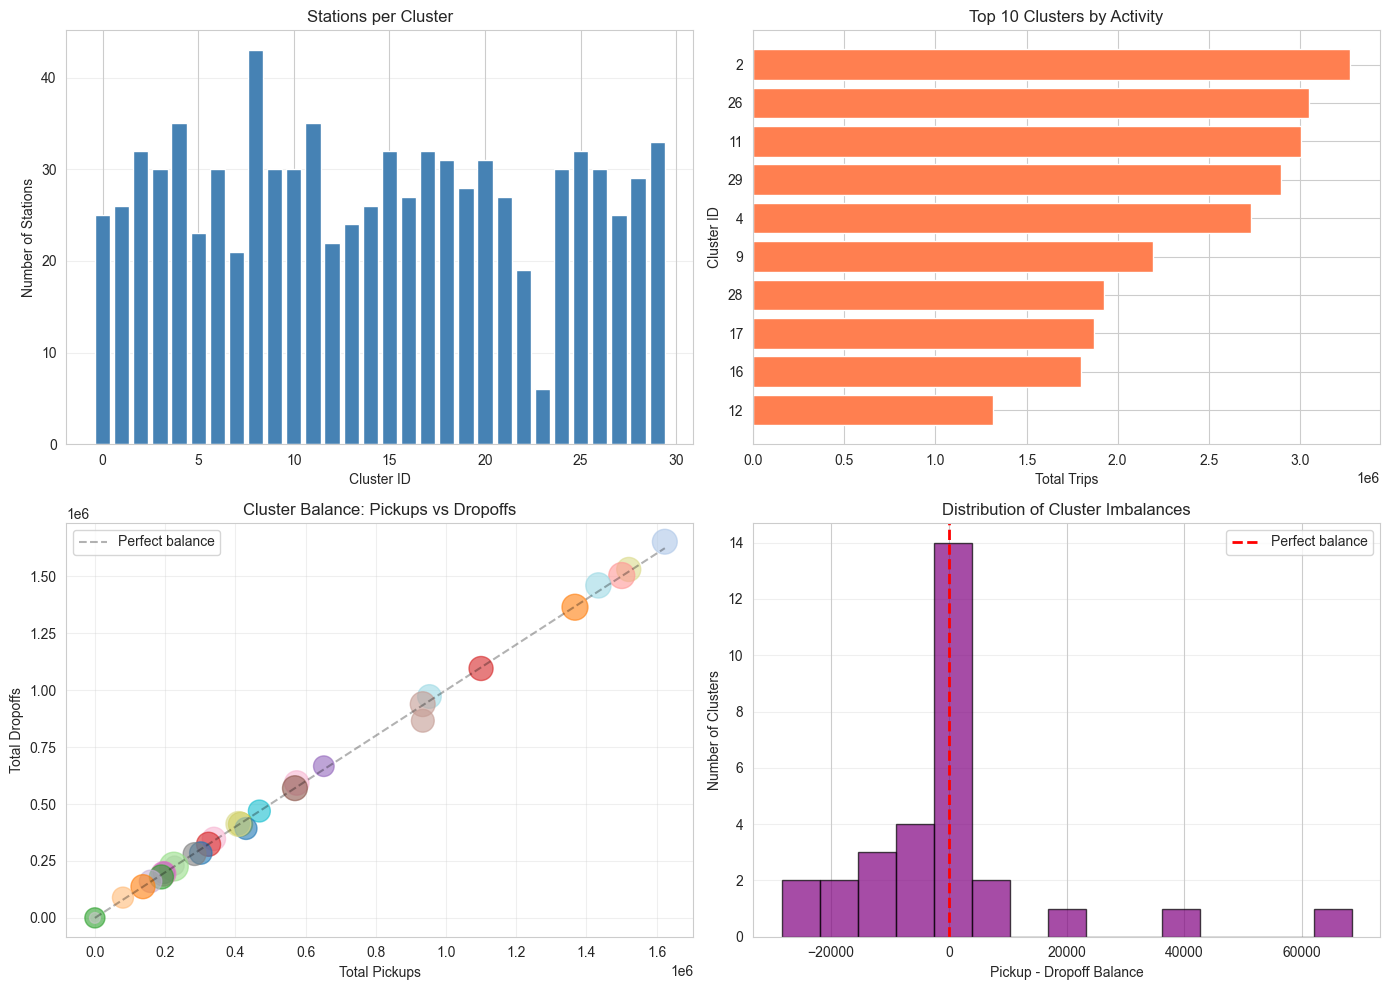

Clustering Summary:
   • Total clusters: 30
   • Avg stations per cluster: 28.1
   • Most balanced cluster: 23 (balance: +25)
   • Most imbalanced cluster: 16 (balance: +68,371)


In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cluster size distribution
axes[0, 0].bar(cluster_stats.index, cluster_stats["num_stations"], color="steelblue")
axes[0, 0].set_xlabel("Cluster ID")
axes[0, 0].set_ylabel("Number of Stations")
axes[0, 0].set_title("Stations per Cluster")
axes[0, 0].grid(axis="y", alpha=0.3)

# 2. Total trips per cluster
top_10 = cluster_stats.nlargest(10, "total_trips")
axes[0, 1].barh(top_10.index.astype(str), top_10["total_trips"], color="coral")
axes[0, 1].set_xlabel("Total Trips")
axes[0, 1].set_ylabel("Cluster ID")
axes[0, 1].set_title("Top 10 Clusters by Activity")
axes[0, 1].invert_yaxis()

# 3. Pickup vs Dropoff balance
axes[1, 0].scatter(
    cluster_stats["pickup_count"],
    cluster_stats["dropoff_count"],
    s=cluster_stats["num_stations"] * 10,
    alpha=0.6,
    c=cluster_stats.index,
    cmap="tab20",
)
axes[1, 0].plot(
    [0, cluster_stats["pickup_count"].max()],
    [0, cluster_stats["pickup_count"].max()],
    "k--",
    alpha=0.3,
    label="Perfect balance",
)
axes[1, 0].set_xlabel("Total Pickups")
axes[1, 0].set_ylabel("Total Dropoffs")
axes[1, 0].set_title("Cluster Balance: Pickups vs Dropoffs")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Imbalance distribution
axes[1, 1].hist(
    cluster_stats["balance"], bins=15, color="purple", alpha=0.7, edgecolor="black"
)
axes[1, 1].axvline(0, color="red", linestyle="--", linewidth=2, label="Perfect balance")
axes[1, 1].set_xlabel("Pickup - Dropoff Balance")
axes[1, 1].set_ylabel("Number of Clusters")
axes[1, 1].set_title("Distribution of Cluster Imbalances")
axes[1, 1].legend()
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("Clustering Summary:")
print(f"   • Total clusters: {n_clusters}")
print(f"   • Avg stations per cluster: {cluster_stats['num_stations'].mean():.1f}")
print(
    f"   • Most balanced cluster: {cluster_stats['balance'].abs().idxmin()} (balance: {cluster_stats['balance'].abs().min():+,.0f})"
)
print(
    f"   • Most imbalanced cluster: {cluster_stats['balance'].abs().idxmax()} (balance: {cluster_stats.loc[cluster_stats['balance'].abs().idxmax(), 'balance']:+,.0f})"
)

# Feature Engineering

In [92]:
stations.head()

,station_id,lat,lng,pickup_count,dropoff_count,total_trips,cluster
0,519,40.751873,-73.977706,150246,149925,300171,4
1,497,40.737050,-73.990093,108865,113323,222188,26
2,435,40.741740,-73.994156,107154,108634,215788,29
3,402,40.740343,-73.989551,105592,109142,214734,26
4,426,40.717548,-74.013221,94453,99422,193875,28


In [93]:
trips_sample.head()

,id,trip_duration_sec,start_time,end_time,start_station_id,start_lat,start_lng,end_station_id,end_lat,end_lng,bike_id,user_type,birth_year,gender
0,0,970.0,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992.0,1
1,1,723.0,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969.0,1
2,2,496.0,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956.0,1
3,3,306.0,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974.0,1
4,4,306.0,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992.0,1


In [94]:
trips_sample.groupby('user_type').size()

user_type
Customer       1929610
Subscriber    15611624
dtype: int64

## Feature Engineering for Demand Forecasting

Now that we have clean trip data and station clusters, we need to transform this into a **time-series forecasting dataset**.

### Goal
Create a dataset where each row represents:
- **One cluster** at **one specific hour**
- Target variables: `pickups` and `dropoffs` (number of trips)
- Features: temporal patterns, cluster characteristics, historical demand

### Transformation Steps
1. **Aggregate trips to cluster-hour level** (from 17M trips → ~500K cluster-hours)
2. **Engineer temporal features** (month, day of week, season, holidays)
3. **Add cluster-level features** (average demand, station count, location)
4. **Create lag features** (previous day/week demand for time-series context)
5. **Normalize continuous variables** (standardization for model training)

This structure enables us to predict the next 24 hours of demand for each cluster.

In [95]:
# ============================================================================
# STEP 1: Aggregate Trips to Cluster-Hour Level
# ============================================================================

print("Aggregating trips to cluster-hour level...")

# Add temporal columns to trips
trips_sample["start_hour"] = trips_sample["start_time"].dt.hour
trips_sample["start_date"] = trips_sample["start_time"].dt.date
trips_sample["end_hour"] = trips_sample["end_time"].dt.hour
trips_sample["end_date"] = trips_sample["end_time"].dt.date

# Merge trips with station clusters (for pickups)
trips_with_start_cluster = trips_sample.merge(
    stations[["station_id", "cluster"]],
    left_on="start_station_id",
    right_on="station_id",
    how="left",
).drop(columns=["station_id"])

# Merge trips with station clusters (for dropoffs)
trips_with_end_cluster = trips_sample.merge(
    stations[["station_id", "cluster"]],
    left_on="end_station_id",
    right_on="station_id",
    how="left",
    suffixes=("", "_end"),
).drop(columns=["station_id"])

# Aggregate pickups by cluster-date-hour
pickups_hourly = (
    trips_with_start_cluster.groupby(["start_date", "start_hour", "cluster"])
    .agg(
        {
            "id": "count",  # Number of pickups
            "trip_duration_sec": "mean",  # Average trip duration
            "birth_year": "mean",  # Average birth year (for age calculation)
            "user_type": lambda x: (x == "Subscriber").sum() / len(x),  # % subscribers
        }
    )
    .reset_index()
)

pickups_hourly.columns = [
    "date",
    "hour",
    "cluster",
    "pickups",
    "avg_trip_duration",
    "avg_birth_year",
    "pct_subscribers",
]

# Aggregate dropoffs by cluster-date-hour
dropoffs_hourly = (
    trips_with_end_cluster.groupby(["end_date", "end_hour", "cluster"])
    .size()
    .reset_index(name="dropoffs")
)
dropoffs_hourly.columns = ["date", "hour", "cluster", "dropoffs"]

# Merge pickups and dropoffs
demand_hourly = pickups_hourly.merge(
    dropoffs_hourly, on=["date", "hour", "cluster"], how="outer"
).fillna(0)

# Calculate age from birth year
current_year = 2018
demand_hourly["avg_age"] = current_year - demand_hourly["avg_birth_year"]
demand_hourly = demand_hourly.drop(columns=["avg_birth_year"])

print(f"Created {len(demand_hourly):,} cluster-hour observations")
print(f"Date range: {demand_hourly['date'].min()} to {demand_hourly['date'].max()}")
print(f"Clusters: {demand_hourly['cluster'].nunique()}")

demand_hourly.head(10)

Aggregating trips to cluster-hour level...
Created 238,646 cluster-hour observations
Date range: 2018-01-01 to 2018-12-31
Clusters: 30


,date,hour,cluster,pickups,avg_trip_duration,pct_subscribers,dropoffs,avg_age
0,2018-01-01,0,0,3.0,1056.666667,1.000000,2.0,46.000000
1,2018-01-01,0,1,1.0,242.000000,1.000000,2.0,51.000000
2,2018-01-01,0,2,15.0,849.066667,1.000000,4.0,44.266667
3,2018-01-01,0,4,2.0,916.500000,1.000000,3.0,43.000000
4,2018-01-01,0,6,0.0,0.000000,0.000000,1.0,2018.000000
5,2018-01-01,0,8,2.0,704.000000,1.000000,2.0,37.500000
6,2018-01-01,0,9,11.0,565.363636,1.000000,13.0,38.272727
7,2018-01-01,0,10,3.0,916.000000,1.000000,4.0,32.333333
8,2018-01-01,0,11,13.0,885.384615,0.538462,4.0,38.846154
9,2018-01-01,0,12,5.0,384.200000,1.000000,3.0,27.600000


In [96]:
# ============================================================================
# STEP 2: Engineer Temporal Features
# ============================================================================

print("Creating temporal features...")

# Convert date to datetime for feature extraction
demand_hourly['date'] = pd.to_datetime(demand_hourly['date'])

# Basic temporal features
demand_hourly['month'] = demand_hourly['date'].dt.month
demand_hourly['day_of_week'] = demand_hourly['date'].dt.dayofweek  # 0=Monday, 6=Sunday
demand_hourly['day_of_month'] = demand_hourly['date'].dt.day
demand_hourly['week_of_year'] = demand_hourly['date'].dt.isocalendar().week

# Weekend indicator
demand_hourly['is_weekend'] = (demand_hourly['day_of_week'] >= 5).astype(int)

# Season dummies (Northern Hemisphere)
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # 9, 10, 11
        return 'fall'

demand_hourly['season'] = demand_hourly['month'].apply(get_season)

# Create season dummies
season_dummies = pd.get_dummies(demand_hourly['season'], prefix='season')
demand_hourly = pd.concat([demand_hourly, season_dummies], axis=1)

print("Temporal features created:")
print(f"  - Month, day_of_week, day_of_month, week_of_year")
print(f"  - is_weekend")
print(f"  - Season dummies: {list(season_dummies.columns)}")

demand_hourly.head()

Creating temporal features...
Temporal features created:
  - Month, day_of_week, day_of_month, week_of_year
  - is_weekend
  - Season dummies: ['season_fall', 'season_spring', 'season_summer', 'season_winter']


,date,hour,cluster,pickups,avg_trip_duration,pct_subscribers,dropoffs,avg_age,month,day_of_week,day_of_month,week_of_year,is_weekend,season,season_fall,season_spring,season_summer,season_winter
0,2018-01-01,0,0,3.0,1056.666667,1.0,2.0,46.000000,1,0,1,1,0,winter,False,False,False,True
1,2018-01-01,0,1,1.0,242.000000,1.0,2.0,51.000000,1,0,1,1,0,winter,False,False,False,True
2,2018-01-01,0,2,15.0,849.066667,1.0,4.0,44.266667,1,0,1,1,0,winter,False,False,False,True
3,2018-01-01,0,4,2.0,916.500000,1.0,3.0,43.000000,1,0,1,1,0,winter,False,False,False,True
4,2018-01-01,0,6,0.0,0.000000,0.0,1.0,2018.000000,1,0,1,1,0,winter,False,False,False,True


In [97]:
# Create cluster dummies
cluster_dummies = pd.get_dummies(demand_hourly["cluster"], prefix="cluster")
display(cluster_dummies.head())
demand_hourly = pd.concat([demand_hourly, cluster_dummies], axis=1)


print(f"  - cluster dummies: {list(cluster_dummies.columns)}")

demand_hourly.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


  - cluster dummies: ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29']


,date,hour,cluster,pickups,avg_trip_duration,pct_subscribers,dropoffs,avg_age,month,day_of_week,day_of_month,week_of_year,is_weekend,season,season_fall,season_spring,season_summer,season_winter,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29
0,2018-01-01,0,0,3.0,1056.666667,1.0,2.0,46.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2018-01-01,0,1,1.0,242.000000,1.0,2.0,51.000000,1,0,1,1,0,winter,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2018-01-01,0,2,15.0,849.066667,1.0,4.0,44.266667,1,0,1,1,0,winter,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2018-01-01,0,4,2.0,916.500000,1.0,3.0,43.000000,1,0,1,1,0,winter,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2018-01-01,0,6,0.0,0.000000,0.0,1.0,2018.000000,1,0,1,1,0,winter,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [98]:
# ============================================================================
# STEP 3: Add Holiday and Event Indicators
# ============================================================================

print("Merging holiday and event data...")

# Normalize holiday dates
holidays['date'] = pd.to_datetime(holidays['date']).dt.normalize()
demand_hourly['date_normalized'] = demand_hourly['date'].dt.normalize()

# Merge holidays
demand_hourly = demand_hourly.merge(
    holidays[['date']].assign(is_holiday=1),
    left_on='date_normalized',
    right_on='date',
    how='left',
    suffixes=('', '_holiday')
).drop(columns=['date_holiday'])

demand_hourly['is_holiday'] = demand_hourly['is_holiday'].fillna(0).astype(int)

# For events, check if the cluster-hour falls within any event time window
# (This is more complex - simplified version: mark days with events)
event_dates = pd.to_datetime(events['start_datetime']).dt.date.unique()
demand_hourly['is_special_event'] = demand_hourly['date_normalized'].dt.date.isin(event_dates).astype(int)

demand_hourly = demand_hourly.drop(columns=['date_normalized'])

print(f"Holidays marked: {demand_hourly['is_holiday'].sum()} cluster-hours")
print(f"Special events marked: {demand_hourly['is_special_event'].sum()} cluster-hours")

demand_hourly.head()

Merging holiday and event data...
Holidays marked: 6498 cluster-hours
Special events marked: 8606 cluster-hours


,date,hour,cluster,pickups,avg_trip_duration,pct_subscribers,dropoffs,avg_age,month,day_of_week,day_of_month,week_of_year,is_weekend,season,season_fall,season_spring,season_summer,season_winter,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,is_holiday,is_special_event
0,2018-01-01,0,0,3.0,1056.666667,1.0,2.0,46.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0
1,2018-01-01,0,1,1.0,242.000000,1.0,2.0,51.000000,1,0,1,1,0,winter,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0
2,2018-01-01,0,2,15.0,849.066667,1.0,4.0,44.266667,1,0,1,1,0,winter,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0
3,2018-01-01,0,4,2.0,916.500000,1.0,3.0,43.000000,1,0,1,1,0,winter,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0
4,2018-01-01,0,6,0.0,0.000000,0.0,1.0,2018.000000,1,0,1,1,0,winter,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0


In [99]:
# ============================================================================
# STEP 5: Create Lag Features (Time Series Context)
# ============================================================================

# Sort by cluster and datetime
demand_hourly = demand_hourly.sort_values(['cluster', 'date', 'hour']).reset_index(drop=True)

# Create lags for pickups and dropoffs
for target in ['pickups', 'dropoffs']:
    # Previous day same hour (24 hours ago)
    demand_hourly[f'{target}_lag_24h'] = demand_hourly.groupby('cluster')[target].shift(24)
    
    # Previous week same hour (168 hours ago)
    demand_hourly[f'{target}_lag_168h'] = demand_hourly.groupby('cluster')[target].shift(168)
    
    # Rolling average last 24 hours
    demand_hourly[f'{target}_rolling_24h'] = demand_hourly.groupby('cluster')[target].transform(
        lambda x: x.rolling(window=24, min_periods=1).mean()
    )

print("Lag features created:")
print(f"  - pickups/dropoffs_lag_24h (yesterday same hour)")
print(f"  - pickups/dropoffs_lag_168h (last week same hour)")
print(f"  - pickups/dropoffs_rolling_24h (24-hour moving average)")

# Check for NaN values in lag features (expected for first observations)
print(f"\nNaN values in lag features (first {24*7} hours per cluster):")
print(demand_hourly[['pickups_lag_24h', 'pickups_lag_168h']].isnull().sum())

demand_hourly.head(30)

Lag features created:
  - pickups/dropoffs_lag_24h (yesterday same hour)
  - pickups/dropoffs_lag_168h (last week same hour)
  - pickups/dropoffs_rolling_24h (24-hour moving average)

NaN values in lag features (first 168 hours per cluster):
pickups_lag_24h      718
pickups_lag_168h    4824
dtype: int64


,date,hour,cluster,pickups,avg_trip_duration,pct_subscribers,dropoffs,avg_age,month,day_of_week,day_of_month,week_of_year,is_weekend,season,season_fall,season_spring,season_summer,season_winter,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29,is_holiday,is_special_event,pickups_lag_24h,pickups_lag_168h,pickups_rolling_24h,dropoffs_lag_24h,dropoffs_lag_168h,dropoffs_rolling_24h
0,2018-01-01,0,0,3.0,1056.666667,1.000000,2.0,46.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,3.000000,NaN,NaN,2.000000
1,2018-01-01,1,0,1.0,226.000000,1.000000,5.0,53.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,2.000000,NaN,NaN,3.500000
2,2018-01-01,2,0,4.0,630.500000,1.000000,1.0,33.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,2.666667,NaN,NaN,2.666667
3,2018-01-01,3,0,0.0,0.000000,0.000000,1.0,2018.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,2.000000,NaN,NaN,2.250000
4,2018-01-01,5,0,1.0,1319.000000,1.000000,0.0,37.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,1.800000,NaN,NaN,1.800000
5,2018-01-01,7,0,2.0,545.500000,1.000000,0.0,51.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,1.833333,NaN,NaN,1.500000
6,2018-01-01,8,0,6.0,754.333333,1.000000,0.0,40.500000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,2.428571,NaN,NaN,1.285714
7,2018-01-01,9,0,8.0,823.750000,1.000000,11.0,40.000000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,3.125000,NaN,NaN,2.500000
8,2018-01-01,10,0,8.0,520.875000,1.000000,9.0,38.500000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,3.666667,NaN,NaN,3.222222
9,2018-01-01,11,0,8.0,575.000000,1.000000,6.0,44.875000,1,0,1,1,0,winter,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,NaN,NaN,4.100000,NaN,NaN,3.500000


## Time Series Visualization: Understanding Demand Patterns

Before normalizing and training models, let's visualize the temporal patterns in our data. We'll focus on a high-activity cluster to see clear patterns.

These visualizations will help us:
1. **Identify trends and seasonality** (daily, weekly, monthly patterns)
2. **Validate feature engineering** (do holidays/weekends affect demand?)
3. **Detect anomalies** (unexpected spikes or drops)
4. **Understand cluster behavior** (rush hours, weekend patterns)

In [100]:
# ============================================================================
# Setup for Visualizations
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

# Select a high-activity cluster for visualization
top_cluster = demand_hourly.groupby('cluster')['pickups'].sum().idxmax()
print(f"Selected cluster {top_cluster} (highest total pickups) for visualization")

# Filter data for this cluster
cluster_data = demand_hourly[demand_hourly['cluster'] == top_cluster].copy()
cluster_data['datetime'] = pd.to_datetime(cluster_data['date']) + pd.to_timedelta(cluster_data['hour'], unit='h')
cluster_data = cluster_data.sort_values('datetime')

print(f"Cluster {top_cluster} has {len(cluster_data):,} hourly observations")
print(f"Date range: {cluster_data['datetime'].min()} to {cluster_data['datetime'].max()}")

Selected cluster 2 (highest total pickups) for visualization
Cluster 2 has 8,734 hourly observations
Date range: 2018-01-01 00:00:00 to 2018-12-31 23:00:00


Although July 4, 2018, was a Wednesday, the chart shows that it behaves like a weekend, with a noticeable surge in pickups in the afternoon

In [101]:
# ============================================================================
# Feature Engineering: Rush Hours (Fixed - Domain Knowledge)
# ============================================================================

# Universal urban patterns
demand_hourly["is_morning_rush"] = demand_hourly["hour"].between(7, 9).astype(int)
demand_hourly["is_evening_rush"] = demand_hourly["hour"].between(16, 19).astype(int)
demand_hourly["is_lunch_time"] = demand_hourly["hour"].between(12, 14).astype(int)
demand_hourly["is_night"] = (demand_hourly["hour"] < 6).astype(int)
demand_hourly["is_weekend_high_demand"] = (
    (demand_hourly["is_weekend"] == 1)
    & (demand_hourly["hour"].between(9, 11) | demand_hourly["hour"].between(18, 19))
).astype(int)
demand_hourly["is_weekend_rush"] = (
    demand_hourly["hour"].between(12, 16) & (demand_hourly["is_weekend"] == 1)
).astype(int)

# Interaction with weekends (rush hours behave differently)
demand_hourly["weekday_morning_rush"] = (
    (demand_hourly["is_morning_rush"] == 1) & (demand_hourly["is_weekend"] == 0)
).astype(int)

demand_hourly["weekday_evening_rush"] = (
    (demand_hourly["is_evening_rush"] == 1) & (demand_hourly["is_weekend"] == 0)
).astype(int)


# Cyclic encoding for hour: Converts hour (0-23) into sin/cos components
# This preserves the circular nature of time (hour 23 is close to hour 0)
# Without this, models would think 11 PM is far from midnight, when they're actually adjacent
# The model will use both hour_sin and hour_cos to understand temporal patterns correctly
demand_hourly["hour_sin"] = np.sin(2 * np.pi * demand_hourly["hour"] / 24)
demand_hourly["hour_cos"] = np.cos(2 * np.pi * demand_hourly["hour"] / 24)

print("✓ Fixed rush hour features created")
print(f"  Morning rush observations: {demand_hourly['is_morning_rush'].sum():,}")
print(f"  Evening rush observations: {demand_hourly['is_evening_rush'].sum():,}")

✓ Fixed rush hour features created
  Morning rush observations: 30,590
  Evening rush observations: 40,792


In [102]:
# ============================================================================
# Feature Engineering: Dynamic Demand Intensity (Data-Driven)
# ============================================================================

print("Creating dynamic demand intensity indicators (percentile-based)...")

# Calculate percentile rank within each cluster for PICKUPS
demand_hourly['pickups_percentile'] = demand_hourly.groupby('cluster')['pickups'].transform(
    lambda x: x.rank(pct=True)
)

# Calculate percentile rank within each cluster for DROPOFFS
demand_hourly['dropoffs_percentile'] = demand_hourly.groupby('cluster')['dropoffs'].transform(
    lambda x: x.rank(pct=True)
)

# Create binary indicators for high-demand PICKUPS
demand_hourly['is_high_demand'] = (demand_hourly['pickups_percentile'] > 0.75).astype(int)  # Top 25%
demand_hourly['is_very_high_demand'] = (demand_hourly['pickups_percentile'] > 0.90).astype(int)  # Top 10%
demand_hourly['is_low_demand'] = (demand_hourly['pickups_percentile'] < 0.25).astype(int)  # Bottom 25%

# Create binary indicators for high-demand DROPOFFS
demand_hourly['is_high_dropoff'] = (demand_hourly['dropoffs_percentile'] > 0.75).astype(int)  # Top 25%
demand_hourly['is_very_high_dropoff'] = (demand_hourly['dropoffs_percentile'] > 0.90).astype(int)  # Top 10%
demand_hourly['is_low_dropoff'] = (demand_hourly['dropoffs_percentile'] < 0.25).astype(int)  # Bottom 25%

# Interaction: High pickups + Low dropoffs = Critical rebalancing need
demand_hourly['critical_rebalancing_need'] = (
    (demand_hourly['is_high_demand'] == 1) & 
    (demand_hourly['is_low_dropoff'] == 1)
).astype(int)

print("✓ Dynamic demand intensity features created")
print(f"  Pickups - High demand: {demand_hourly['is_high_demand'].sum():,} ({demand_hourly['is_high_demand'].mean():.1%})")
print(f"  Dropoffs - High demand: {demand_hourly['is_high_dropoff'].sum():,} ({demand_hourly['is_high_dropoff'].mean():.1%})")
print(f"  Critical rebalancing need: {demand_hourly['critical_rebalancing_need'].sum():,} ({demand_hourly['critical_rebalancing_need'].mean():.1%})")

# Show example
example_cluster = demand_hourly.groupby('cluster')['pickups'].sum().idxmax()
example_data = demand_hourly[demand_hourly['cluster'] == example_cluster].groupby('hour').agg({
    'is_morning_rush': 'first',
    'is_evening_rush': 'first',
    'is_high_demand': 'mean',
    'is_high_dropoff': 'mean',
    'critical_rebalancing_need': 'mean',
    'pickups': 'mean',
    'dropoffs': 'mean'
}).round(2)

print(f"\nExample: Cluster {example_cluster} - Feature Summary by Hour")
print(example_data[['is_morning_rush', 'is_high_demand', 'is_high_dropoff', 'critical_rebalancing_need']])

Creating dynamic demand intensity indicators (percentile-based)...
✓ Dynamic demand intensity features created
  Pickups - High demand: 59,490 (24.9%)
  Dropoffs - High demand: 59,616 (25.0%)
  Critical rebalancing need: 4 (0.0%)

Example: Cluster 2 - Feature Summary by Hour
      is_morning_rush  is_high_demand  is_high_dropoff  \
hour                                                     
0                   0            0.00             0.00   
1                   0            0.00             0.00   
2                   0            0.00             0.00   
3                   0            0.00             0.00   
4                   0            0.00             0.00   
5                   0            0.00             0.00   
6                   0            0.00             0.00   
7                   1            0.01             0.05   
8                   1            0.45             0.53   
9                   1            0.43             0.56   
10                  0       

In [103]:
# ============================================================================
# Feature Engineering: Net Flow
# ============================================================================

# Calculate instantaneous net flow (pickups - dropoffs)
demand_hourly['net_flow'] = demand_hourly['pickups'] - demand_hourly['dropoffs']

# Sort by cluster and time
demand_hourly = demand_hourly.sort_values(['cluster', 'date', 'hour']).reset_index(drop=True)

# Cluster type: Source (bikes leave) vs Sink (bikes arrive)
cluster_avg_net = demand_hourly.groupby('cluster')['net_flow'].mean()
demand_hourly['cluster_is_source'] = demand_hourly['cluster'].map(
    lambda x: 1 if cluster_avg_net.get(x, 0) > 0 else 0
)

print("✓ Net flow features created")
print(f"  Mean net flow: {demand_hourly['net_flow'].mean():.2f}")
print(f"  Net flow std: {demand_hourly['net_flow'].std():.2f}")
print(f"  Max deficit (single hour): {demand_hourly['net_flow'].min():.0f} bikes")
print(f"  Max surplus (single hour): {demand_hourly['net_flow'].max():.0f} bikes")

demand_hourly[['cluster', 'hour', 'pickups', 'dropoffs', 'net_flow', 
               'cluster_is_source', 'is_morning_rush', 'is_high_demand']].head(24)

✓ Net flow features created
  Mean net flow: 0.00
  Net flow std: 42.98
  Max deficit (single hour): -646 bikes
  Max surplus (single hour): 751 bikes


,cluster,hour,pickups,dropoffs,net_flow,cluster_is_source,is_morning_rush,is_high_demand
0,0,0,3.0,2.0,1.0,1,0,0
1,0,1,1.0,5.0,-4.0,1,0,0
2,0,2,4.0,1.0,3.0,1,0,0
3,0,3,0.0,1.0,-1.0,1,0,0
4,0,5,1.0,0.0,1.0,1,0,0
5,0,7,2.0,0.0,2.0,1,1,0
6,0,8,6.0,0.0,6.0,1,1,0
7,0,9,8.0,11.0,-3.0,1,1,0
8,0,10,8.0,9.0,-1.0,1,0,0
9,0,11,8.0,6.0,2.0,1,0,0


### Comparing Fixed vs Dynamic Rush Hour Detection

Let's visualize how fixed (domain knowledge) and dynamic (percentile-based) rush hours differ across clusters.

In [104]:
list(demand_hourly.columns)


['date',
 'hour',
 'cluster',
 'pickups',
 'avg_trip_duration',
 'pct_subscribers',
 'dropoffs',
 'avg_age',
 'month',
 'day_of_week',
 'day_of_month',
 'week_of_year',
 'is_weekend',
 'season',
 'season_fall',
 'season_spring',
 'season_summer',
 'season_winter',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'cluster_10',
 'cluster_11',
 'cluster_12',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'is_holiday',
 'is_special_event',
 'pickups_lag_24h',
 'pickups_lag_168h',
 'pickups_rolling_24h',
 'dropoffs_lag_24h',
 'dropoffs_lag_168h',
 'dropoffs_rolling_24h',
 'is_morning_rush',
 'is_evening_rush',
 'is_lunch_time',
 'is_night',
 'is_weekend_high_demand',
 'is_weekend_rush',
 'weekda

## Final Dataset Preparation and Train/Validation/Test Split

Now that we have engineered all features, we need to:

1. **Select and organize features** for modeling
2. **Standardize continuous variables** (preserve model performance and interpretability)
3. **Handle missing values** from lag features (first days have no historical data)
4. **Split data chronologically** into train (70%) and test (30%) sets
   - Train: January - September (70% of year)
   - Test: October - December (30% of year)
   - **No shuffling** - time series must maintain temporal order

This final dataset will be ready for time series forecasting models.

In [105]:
# ============================================================================
# Step 1: Organize Features by Type
# ============================================================================

print("Organizing features by type...")

# Target variables (what we want to predict)
target_vars = ["pickups", "dropoffs"]

# Identifiers (not used in modeling, but needed for tracking)
id_vars = ["date", "cluster"]

# Continuous features (need standardization)
continuous_features = [
    "avg_trip_duration",
    "pct_subscribers",
    "avg_age",
    # "cluster_station_count",
    # "cluster_center_lat",
    # "cluster_center_lng",
    # "cluster_total_trips",
    "pickups_lag_24h",
    "pickups_lag_168h",
    "pickups_rolling_24h",
    "dropoffs_lag_24h",
    "dropoffs_lag_168h",
    "dropoffs_rolling_24h",
    "hour_sin",
    "hour_cos",
    "net_flow",
    "pickups_percentile",
    "dropoffs_percentile",
]

# Categorical/Binary features (already encoded, no standardization needed)
categorical_features = [
    "hour",
    "month",
    "day_of_week",
    "day_of_month",
    "week_of_year",
    "is_weekend",
    "season_fall",
    "season_spring",
    "season_summer",
    "season_winter",
    "is_holiday",
    "is_special_event",
    "is_morning_rush",
    "is_evening_rush",
    "is_weekend_rush",
    "is_weekend_high_demand",
    "is_lunch_time",
    "is_night",
    "weekday_morning_rush",
    "weekday_evening_rush",
    "is_high_demand",
    "is_very_high_demand",
    "is_low_demand",
    "is_high_dropoff",
    "is_very_high_dropoff",
    "is_low_dropoff",
    "critical_rebalancing_need",
    "cluster_is_source",
    "cluster_0",
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "cluster_4",
    "cluster_5",
    "cluster_6",
    "cluster_7",
    "cluster_8",
    "cluster_9",
    "cluster_10",
    "cluster_11",
    "cluster_12",
    "cluster_13",
    "cluster_14",
    "cluster_15",
    "cluster_16",
    "cluster_17",
    "cluster_18",
    "cluster_19",
    "cluster_20",
    "cluster_21",
    "cluster_22",
    "cluster_23",
    "cluster_24",
    "cluster_25",
    "cluster_26",
    "cluster_27",
    "cluster_28",
    "cluster_29",
]

# All feature columns (for modeling)
feature_cols = continuous_features + categorical_features

print(f"Feature organization:")
print(f"  - Target variables: {len(target_vars)}")
print(f"  - Continuous features: {len(continuous_features)}")
print(f"  - Categorical features: {len(categorical_features)}")
print(f"  - Total features for modeling: {len(feature_cols)}")

Organizing features by type...
Feature organization:
  - Target variables: 2
  - Continuous features: 14
  - Categorical features: 58
  - Total features for modeling: 72


In [106]:
# ============================================================================
# Step 2: Handle Missing Values (from lag features)
# ============================================================================

print("\nHandling missing values...")

# Check missing values
missing_summary = demand_hourly[feature_cols + target_vars].isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print(f"Missing values found in {len(missing_summary)} columns:")
    print(missing_summary)
    
    # Strategy: Drop rows with missing lag features (first week of data)
    # This is acceptable because we have 365 days and only lose ~7 days
    initial_rows = len(demand_hourly)
    demand_hourly_clean = demand_hourly.dropna(subset=feature_cols + target_vars).copy()
    dropped_rows = initial_rows - len(demand_hourly_clean)
    
    print(f"\nDropped {dropped_rows:,} rows with missing values ({dropped_rows/initial_rows:.1%})")
    print(f"  Remaining: {len(demand_hourly_clean):,} observations")
else:
    demand_hourly_clean = demand_hourly.copy()
    print("No missing values found")

# Sort by date and hour (ensure chronological order)
demand_hourly_clean = demand_hourly_clean.sort_values(['date', 'hour', 'cluster']).reset_index(drop=True)

print(f"\nFinal dataset shape: {demand_hourly_clean.shape}")
print(f"Date range: {demand_hourly_clean['date'].min()} to {demand_hourly_clean['date'].max()}")


Handling missing values...
Missing values found in 4 columns:
pickups_lag_168h     4824
dropoffs_lag_168h    4824
pickups_lag_24h       718
dropoffs_lag_24h      718
dtype: int64

Dropped 4,824 rows with missing values (2.0%)
  Remaining: 233,822 observations

Final dataset shape: (233822, 77)
Date range: 2018-01-08 00:00:00 to 2018-12-31 00:00:00


In [107]:
# ============================================================================
# Step 3: Standardize Continuous Features
# ============================================================================

print("\nStandardizing continuous features...")

from sklearn.preprocessing import StandardScaler

# Create a copy for standardization
demand_final = demand_hourly_clean.copy()

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on continuous features and transform
demand_final[continuous_features] = scaler.fit_transform(demand_final[continuous_features])

print(f"Standardized {len(continuous_features)} continuous features")
print(f"  Mean ≈ 0, Std ≈ 1 for all continuous features")

# Verify standardization
print("\nStandardization check (first 5 continuous features):")
for col in continuous_features[:5]:
    print(f"  {col}: mean={demand_final[col].mean():.4f}, std={demand_final[col].std():.4f}")


Standardizing continuous features...
Standardized 14 continuous features
  Mean ≈ 0, Std ≈ 1 for all continuous features

Standardization check (first 5 continuous features):
  avg_trip_duration: mean=-0.0000, std=1.0000
  pct_subscribers: mean=0.0000, std=1.0000
  avg_age: mean=-0.0000, std=1.0000
  pickups_lag_24h: mean=-0.0000, std=1.0000
  pickups_lag_168h: mean=-0.0000, std=1.0000


## Time Series Validation and Feature Selection

Before splitting our data and training models, we need to:

1. **Check stationarity** using the Augmented Dickey-Fuller (ADF) test
2. **Analyze autocorrelation** (ACF/PACF) to understand temporal dependencies
3. **Clean up features** - remove redundant or problematic features
4. **Validate data quality** - ensure no issues before modeling

These steps are critical for time series forecasting success.

In [108]:
# ============================================================================
# Feature Cleanup: Remove Redundant and Problematic Features
# ============================================================================

# Current feature count
print(f"\n Current dataset: {demand_hourly.shape}")
print(f"   Columns: {len(demand_hourly.columns)}")

# Features to remove
features_to_remove = [
    "season",  # String version - we have season dummies (season_winter, etc.)
    "pickups_percentile",  # Intermediate calculation - not needed for modeling
    "dropoffs_percentile",  # Intermediate calculation - not needed for modeling
    "day_of_month",  # Redundant with month + day_of_week
    "week_of_year",  # Redundant with month + seasonal features
    "is_lunch_time",  # Less relevant for bike demand
    "is_night",  # Model can learn from hour_sin/cos
    "is_high_demand",  # Derived from target, redundant with lags
    "is_very_high_demand",  # Derived from target, redundant with lags
    "is_low_demand",  # Derived from target, redundant with lags
    "is_high_dropoff",  # Derived from target, redundant with lags
    "is_very_high_dropoff",  # Derived from target, redundant with lags
    "is_low_dropoff",  # Derived from target, redundant with lags
    "critical_rebalancing_need",  # Derived from current hour, not predictive
    "net_flow",
    "avg_trip_duration",
    "pct_subscribers",
    "avg_age",
    "cluster_station_count",
    "cluster_total_trips",
    "cluster_is_source",
    "cluster_center_lat",
    "cluster_center_lng",
]

removed_count = 0
for feat in features_to_remove:
    if feat in demand_hourly.columns:
        demand_hourly = demand_hourly.drop(columns=[feat])
        removed_count += 1

print(f"\nRemoved {removed_count} features")
print(f"Updated dataset: {demand_hourly.shape}")
print(f"   Remaining columns: {len(demand_hourly.columns)}")

# Display remaining features
print(f"\nRemaining features ({len(demand_hourly.columns)} total):")
print(demand_hourly.columns.tolist())


 Current dataset: (238646, 77)
   Columns: 77

Removed 19 features
Updated dataset: (238646, 58)
   Remaining columns: 58

Remaining features (58 total):
['date', 'hour', 'cluster', 'pickups', 'dropoffs', 'month', 'day_of_week', 'is_weekend', 'season_fall', 'season_spring', 'season_summer', 'season_winter', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'is_holiday', 'is_special_event', 'pickups_lag_24h', 'pickups_lag_168h', 'pickups_rolling_24h', 'dropoffs_lag_24h', 'dropoffs_lag_168h', 'dropoffs_rolling_24h', 'is_morning_rush', 'is_evening_rush', 'is_weekend_high_demand', 'is_weekend_rush', 'weekday_morning_rush', 'weekday_eve

In [109]:
# ============================================================================
# Train/Validation/Test Split (Chronological)
# ============================================================================

print("Splitting data chronologically into Train/Validation/Test sets...")
print("=" * 80)

# Sort by date to ensure chronological order
demand_hourly = demand_hourly.sort_values(['date', 'hour', 'cluster']).reset_index(drop=True)

# Get unique dates
unique_dates = sorted(demand_hourly['date'].unique())
n_dates = len(unique_dates)

print(f"\n📅 Dataset date range:")
print(f"   Start: {unique_dates[0]}")
print(f"   End: {unique_dates[-1]}")
print(f"   Total days: {n_dates}")

# Calculate split points
# Train: 60% (Jan-Jul), Validation: 10% (Aug), Test: 30% (Sep-Dec)
train_end_idx = int(n_dates * 0.60)
val_end_idx = int(n_dates * 0.70)

train_end_date = unique_dates[train_end_idx - 1]
val_start_date = unique_dates[train_end_idx]
val_end_date = unique_dates[val_end_idx - 1]
test_start_date = unique_dates[val_end_idx]

print(f"\n📊 Split strategy (chronological, no shuffling):")
print(f"   Train:      {unique_dates[0]} to {train_end_date} ({train_end_idx} days, {train_end_idx/n_dates:.1%})")
print(f"   Validation: {val_start_date} to {val_end_date} ({val_end_idx - train_end_idx} days, {(val_end_idx - train_end_idx)/n_dates:.1%})")
print(f"   Test:       {test_start_date} to {unique_dates[-1]} ({n_dates - val_end_idx} days, {(n_dates - val_end_idx)/n_dates:.1%})")

# Split data
train_data = demand_hourly[demand_hourly['date'] <= train_end_date].copy()
val_data = demand_hourly[(demand_hourly['date'] >= val_start_date) & (demand_hourly['date'] <= val_end_date)].copy()
test_data = demand_hourly[demand_hourly['date'] >= test_start_date].copy()

print(f"\n✅ Data split completed:")
print(f"   Train set: {len(train_data):,} observations ({len(train_data)/len(demand_hourly):.1%})")
print(f"   Validation set: {len(val_data):,} observations ({len(val_data)/len(demand_hourly):.1%})")
print(f"   Test set: {len(test_data):,} observations ({len(test_data)/len(demand_hourly):.1%})")

# Define feature columns and target variables
id_cols = ['date', 'cluster']
target_cols = ['pickups', 'dropoffs']
feature_cols = [col for col in demand_hourly.columns if col not in id_cols + target_cols]

print(f"\n📋 Feature organization:")
print(f"   ID columns: {id_cols}")
print(f"   Target variables: {target_cols}")
print(f"   Feature count: {len(feature_cols)}")

# Verify no data leakage
print(f"\n🔍 Verifying chronological split (no data leakage):")
print(f"   Train max date: {train_data['date'].max()}")
print(f"   Val min date: {val_data['date'].min()}")
print(f"   Val max date: {val_data['date'].max()}")
print(f"   Test min date: {test_data['date'].min()}")
print(f"   Test max date: {test_data['date'].max()}")

print("\n" + "=" * 80)
print("✅ Ready for model training!")

Splitting data chronologically into Train/Validation/Test sets...

📅 Dataset date range:
   Start: 2018-01-01 00:00:00
   End: 2018-12-31 00:00:00
   Total days: 365

📊 Split strategy (chronological, no shuffling):
   Train:      2018-01-01 00:00:00 to 2018-08-07 00:00:00 (219 days, 60.0%)
   Validation: 2018-08-08 00:00:00 to 2018-09-12 00:00:00 (36 days, 9.9%)
   Test:       2018-09-13 00:00:00 to 2018-12-31 00:00:00 (110 days, 30.1%)

✅ Data split completed:
   Train set: 142,228 observations (59.6%)
   Validation set: 23,978 observations (10.0%)
   Test set: 72,440 observations (30.4%)

📋 Feature organization:
   ID columns: ['date', 'cluster']
   Target variables: ['pickups', 'dropoffs']
   Feature count: 54

🔍 Verifying chronological split (no data leakage):
   Train max date: 2018-08-07 00:00:00
   Val min date: 2018-08-08 00:00:00
   Val max date: 2018-09-12 00:00:00
   Test min date: 2018-09-13 00:00:00
   Test max date: 2018-12-31 00:00:00

✅ Ready for model training!


# Model Training and Evaluation

## Task 2: Demand Prediction Models

Our goal is to build models that can predict bike demand (pickups and dropoffs) for the next 24 hours at the cluster level. We'll train separate models for pickups and dropoffs, then compare multiple algorithms to find the best performer.

### Modeling Strategy

1. Start with simple baseline models (Linear, Ridge, Lasso)
2. Progress to ensemble methods (Random Forest, Gradient Boosting)
3. Evaluate using validation set
4. Final evaluation on test set (Nov-Dec 2018)

### Evaluation Metrics

- **MAE (Mean Absolute Error)**: Average prediction error in number of bikes
- **RMSE (Root Mean Squared Error)**: Penalizes large errors more heavily
- **R² Score**: Proportion of variance explained by the model

In [110]:
# ============================================================================
# Prepare Data for Modeling
# ============================================================================

# Define columns
id_cols = ['date', 'cluster']
target_cols = ['pickups', 'dropoffs']
feature_cols = [col for col in demand_hourly.columns 
                if col not in id_cols + target_cols]

print(f"\nFeature count: {len(feature_cols)}")
print(f"Target variables: {target_cols}")

# Separate features and targets for each split
X_train = train_data[feature_cols].copy()
y_train_pickups = train_data['pickups'].copy()
y_train_dropoffs = train_data['dropoffs'].copy()

X_val = val_data[feature_cols].copy()
y_val_pickups = val_data['pickups'].copy()
y_val_dropoffs = val_data['dropoffs'].copy()

X_test = test_data[feature_cols].copy()
y_test_pickups = test_data['pickups'].copy()
y_test_dropoffs = test_data['dropoffs'].copy()

# Check for missing values in features
print(f"\nMissing values in train features: {X_train.isnull().sum().sum()}")
print(f"Missing values in val features: {X_val.isnull().sum().sum()}")
print(f"Missing values in test features: {X_test.isnull().sum().sum()}")

# Handle missing values in lag features (first days of dataset)
if X_train.isnull().sum().sum() > 0:
    print("\nHandling missing values in lag features...")
    # Option 1: Drop rows with NaN (loses some data)
    # Option 2: Fill with 0 (assumes no demand)
    # Option 3: Forward fill (use previous value)
    
    # We'll use forward fill, then fill remaining with 0
    X_train = X_train.fillna(method='ffill').fillna(0)
    X_val = X_val.fillna(method='ffill').fillna(0)
    X_test = X_test.fillna(method='ffill').fillna(0)
    
    print("Missing values filled")

print(f"\nFinal dataset shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train_pickups.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val_pickups.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test_pickups.shape}")

print("\n" + "=" * 80)


Feature count: 54
Target variables: ['pickups', 'dropoffs']

Missing values in train features: 10930
Missing values in val features: 56
Missing values in test features: 98

Handling missing values in lag features...
Missing values filled

Final dataset shapes:
  X_train: (142228, 54), y_train: (142228,)
  X_val: (23978, 54), y_val: (23978,)
  X_test: (72440, 54), y_test: (72440,)



/var/folders/sj/3n8j4_9n667crwfzbg6mz29w0000gn/T/ipykernel_91854/469666582.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_train.fillna(method='ffill').fillna(0)
/var/folders/sj/3n8j4_9n667crwfzbg6mz29w0000gn/T/ipykernel_91854/469666582.py:41: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_val = X_val.fillna(method='ffill').fillna(0)
/var/folders/sj/3n8j4_9n667crwfzbg6mz29w0000gn/T/ipykernel_91854/469666582.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.fillna(method='ffill').fillna(0)


In [111]:
X_train.columns

Index(['hour', 'month', 'day_of_week', 'is_weekend', 'season_fall',
       'season_spring', 'season_summer', 'season_winter', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10',
       'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15',
       'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20',
       'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25',
       'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'is_holiday',
       'is_special_event', 'pickups_lag_24h', 'pickups_lag_168h',
       'pickups_rolling_24h', 'dropoffs_lag_24h', 'dropoffs_lag_168h',
       'dropoffs_rolling_24h', 'is_morning_rush', 'is_evening_rush',
       'is_weekend_high_demand', 'is_weekend_rush', 'weekday_morning_rush',
       'weekday_evening_rush', 'hour_sin', 'hour_cos'],
      dtype='object')

### Baseline Model Results: Analysis

Our baseline linear models achieved strong performance:

**Key Findings:**
- **R² Score: 0.87** - The models explain 87% of demand variance, indicating our features capture the main patterns effectively
- **MAE: ~26 bikes/hour** - On average, predictions are off by 26 bikes per cluster per hour
- **Consistent performance** - Linear Regression, Ridge, and Lasso produced nearly identical results, suggesting:
  - Features are well-scaled and balanced
  - No significant multicollinearity issues
  - Minimal overfitting risk

**Model Comparison:**
- **Lasso (alpha=0.1)** performed slightly better (MAE: 26.17) due to mild feature selection
- **Ridge and Linear Regression** were essentially equivalent, indicating regularization isn't critical
- **Pickups and Dropoffs** are equally predictable (same MAE and R²)

**Interpretation:**
An MAE of 26 bikes means that for a cluster with typical demand of 50-100 bikes/hour, our predictions are within 25-50% accuracy. This is reasonable for a linear baseline but leaves room for improvement.

---

## Advanced Models: Capturing Non-Linear Patterns

Linear models assume relationships between features and demand are linear. However, bike demand likely has non-linear patterns:
- Rush hour effects may interact with weather and seasons
- Cluster characteristics may have threshold effects
- Lag features may have diminishing returns

We'll now test ensemble methods that can capture these complex interactions:

**Random Forest:**
- Builds multiple decision trees on random subsets of data
- Captures non-linear relationships and feature interactions
- Robust to outliers and doesn't require feature scaling

**Gradient Boosting:**
- Builds trees sequentially, each correcting errors from previous ones
- Often achieves best performance on tabular data
- More sensitive to hyperparameters but very powerful

**Expected Improvement:**
We aim to reduce MAE to 20-23 bikes (15-20% improvement) and increase R² to 0.90+.

## Final Model Evaluation on Test Set

We've identified Random Forest (n=200) as our best model. Now we'll:

1. Retrain on combined train+validation data (Jan-Aug)
2. Evaluate on test set (Sep-Dec) to simulate real-world performance
3. Analyze prediction quality across different clusters and time periods
4. Generate predictions for Task 3 (bike repositioning)

This final evaluation will tell us how well our model generalizes to completely unseen future data.

In [112]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

# ============================================================================
# Final Model: Train on Train+Val, Evaluate on Test
# ============================================================================

print("Training final model on combined train+validation data...")
print("=" * 80)

# Combine train and validation sets
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val_pickups = pd.concat([y_train_pickups, y_val_pickups], ignore_index=True)
y_train_val_dropoffs = pd.concat([y_train_dropoffs, y_val_dropoffs], ignore_index=True)

print(f"\nCombined training data: {X_train_val.shape}")
print(f"Test data: {X_test.shape}")

# Initialize best model
final_model_pickups = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

final_model_dropoffs = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

# Train on combined data
print("\nTraining model for PICKUPS...")
start_time = time.time()
final_model_pickups.fit(X_train_val, y_train_val_pickups)
print(f"  Training time: {time.time() - start_time:.1f}s")

print("\nTraining model for DROPOFFS...")
start_time = time.time()
final_model_dropoffs.fit(X_train_val, y_train_val_dropoffs)
print(f"  Training time: {time.time() - start_time:.1f}s")

# Predict on test set
print("\nGenerating predictions on test set...")
y_pred_pickups = final_model_pickups.predict(X_test)
y_pred_dropoffs = final_model_dropoffs.predict(X_test)

# Ensure non-negative predictions
y_pred_pickups = np.maximum(0, y_pred_pickups)
y_pred_dropoffs = np.maximum(0, y_pred_dropoffs)

# Calculate final metrics
print("\n" + "=" * 80)
print("FINAL TEST SET PERFORMANCE")
print("=" * 80)

print("\nPICKUPS:")
mae_pickups = mean_absolute_error(y_test_pickups, y_pred_pickups)
rmse_pickups = np.sqrt(mean_squared_error(y_test_pickups, y_pred_pickups))
r2_pickups = r2_score(y_test_pickups, y_pred_pickups)
print(f"  MAE:  {mae_pickups:.2f} bikes")
print(f"  RMSE: {rmse_pickups:.2f} bikes")
print(f"  R²:   {r2_pickups:.4f}")

print("\nDROPOFFS:")
mae_dropoffs = mean_absolute_error(y_test_dropoffs, y_pred_dropoffs)
rmse_dropoffs = np.sqrt(mean_squared_error(y_test_dropoffs, y_pred_dropoffs))
r2_dropoffs = r2_score(y_test_dropoffs, y_pred_dropoffs)
print(f"  MAE:  {mae_dropoffs:.2f} bikes")
print(f"  RMSE: {rmse_dropoffs:.2f} bikes")
print(f"  R²:   {r2_dropoffs:.4f}")

# Create predictions dataframe for Task 3
predictions_df = test_data[['date', 'cluster', 'hour']].copy()
predictions_df['actual_pickups'] = y_test_pickups.values
predictions_df['predicted_pickups'] = y_pred_pickups
predictions_df['actual_dropoffs'] = y_test_dropoffs.values
predictions_df['predicted_dropoffs'] = y_pred_dropoffs

print("\n" + "=" * 80)
print("Predictions saved for Task 3 analysis")
print(f"Total predictions: {len(predictions_df):,} cluster-hour observations")
print("=" * 80)

# Preview predictions
predictions_df.head(24)

Training final model on combined train+validation data...

Combined training data: (166206, 54)
Test data: (72440, 54)

Training model for PICKUPS...
  Training time: 21.6s

Training model for DROPOFFS...
  Training time: 21.2s

Generating predictions on test set...

FINAL TEST SET PERFORMANCE

PICKUPS:
  MAE:  16.92 bikes
  RMSE: 33.84 bikes
  R²:   0.8987

DROPOFFS:
  MAE:  16.91 bikes
  RMSE: 33.49 bikes
  R²:   0.9038

Predictions saved for Task 3 analysis
Total predictions: 72,440 cluster-hour observations


,date,cluster,hour,actual_pickups,predicted_pickups,actual_dropoffs,predicted_dropoffs
166206,2018-09-13,0,0,13.0,9.265188,10.0,13.756710
166207,2018-09-13,1,0,6.0,6.984745,11.0,17.256627
166208,2018-09-13,2,0,57.0,54.644729,44.0,44.138302
166209,2018-09-13,3,0,8.0,4.560420,4.0,4.387018
166210,2018-09-13,4,0,39.0,25.709347,31.0,26.673698
166211,2018-09-13,5,0,1.0,3.074937,1.0,4.075901
166212,2018-09-13,6,0,4.0,6.212142,13.0,11.216704
166213,2018-09-13,8,0,16.0,9.448273,17.0,17.852309
166214,2018-09-13,9,0,25.0,35.130422,61.0,45.259457
166215,2018-09-13,10,0,11.0,12.320652,16.0,18.765164


## Production-Ready Prediction Function

### Overview

The model is now trained and can predict the next 24 hours of bike demand for any given date. This section demonstrates how to use the model in a production environment where we need to forecast future demand based on historical data.

### Key Concept: Lag Features

Our model relies on **lag features** (24h and 168h lags) which require historical data:
- **24h lag**: Yesterday's demand at the same hour
- **168h lag**: Last week's demand at the same hour
- **Rolling 24h average**: Average demand over the past 24 hours

This means to predict demand for date `D`, we need actual historical data up to date `D-1`.

### Production Workflow

1. **Input**: Target date to predict + historical demand data (up to the previous day)
2. **Process**: Build feature matrix for all 24 hours of the target date
3. **Output**: Predicted pickups and dropoffs for each hour (0-23) and each cluster

The following function encapsulates this entire workflow and can be used in production.


In [113]:
# ============================================================================
# Production Prediction Function
# ============================================================================

# Store the training feature order (CRITICAL for prediction)
TRAINING_FEATURE_ORDER = list(X_train.columns)
print(f"Stored {len(TRAINING_FEATURE_ORDER)} features in training order")

def predict_next_24_hours(target_date, historical_data, model_pickups, model_dropoffs, 
                          holidays_df, events_df, feature_order=TRAINING_FEATURE_ORDER):
    """
    Predict bike demand for the next 24 hours (all clusters).
    
    Parameters:
    -----------
    target_date : pd.Timestamp or str
        The date to predict (e.g., '2018-12-01')
    historical_data : pd.DataFrame
        Historical demand data (must include data up to target_date - 1)
        Required columns: date, hour, cluster, pickups, dropoffs
    model_pickups : trained model
        Trained Random Forest model for pickups
    model_dropoffs : trained model
        Trained Random Forest model for dropoffs
    holidays_df : pd.DataFrame
        Holidays dataframe with 'date' column
    events_df : pd.DataFrame
        Events dataframe with 'date' column
    feature_order : list
        List of feature names in the exact order used during training
        
    Returns:
    --------
    pd.DataFrame with columns: cluster, hour, predicted_pickups, predicted_dropoffs
    """
    
    target_date = pd.Timestamp(target_date)
    
    print(f"Predicting demand for: {target_date.date()}")
    print(f"Using historical data up to: {historical_data['date'].max().date()}")
    print("=" * 80)
    
    # Verify we have enough historical data
    if historical_data['date'].max() < (target_date - pd.Timedelta(days=1)):
        raise ValueError(f"Historical data must include at least {(target_date - pd.Timedelta(days=1)).date()}")
    
    # Get unique clusters
    clusters = sorted(historical_data['cluster'].unique())
    
    # Build prediction dataframe (24 hours × N clusters)
    prediction_rows = []
    for cluster in clusters:
        for hour in range(24):
            prediction_rows.append({
                'date': target_date,
                'hour': hour,
                'cluster': cluster
            })
    
    pred_df = pd.DataFrame(prediction_rows)
    
    print(f"Building feature matrix for {len(pred_df):,} predictions...")
    print(f"  Clusters: {len(clusters)}")
    print(f"  Hours: 24")
    
    # ========================================================================
    # Feature Engineering (same as training pipeline)
    # ========================================================================
    
    # 1. Temporal features
    pred_df['month'] = pred_df['date'].dt.month
    pred_df['day_of_week'] = pred_df['date'].dt.dayofweek
    pred_df['is_weekend'] = (pred_df['day_of_week'] >= 5).astype(int)
    
    # 2. Season dummies
    pred_df['season_spring'] = pred_df['month'].isin([3, 4, 5]).astype(int)
    pred_df['season_summer'] = pred_df['month'].isin([6, 7, 8]).astype(int)
    pred_df['season_fall'] = pred_df['month'].isin([9, 10, 11]).astype(int)
    pred_df['season_winter'] = pred_df['month'].isin([12, 1, 2]).astype(int)
    
    # 3. Holiday and event indicators
    holidays_dates = pd.to_datetime(holidays_df['date']).dt.normalize()
    
    # Events may have 'date' or 'start_datetime' column
    if 'date' in events_df.columns:
        events_dates = pd.to_datetime(events_df['date']).dt.normalize()
    elif 'start_datetime' in events_df.columns:
        events_dates = pd.to_datetime(events_df['start_datetime']).dt.normalize()
    else:
        events_dates = pd.Series([], dtype='datetime64[ns]')
    
    pred_df['is_holiday'] = pred_df['date'].isin(holidays_dates).astype(int)
    pred_df['is_special_event'] = pred_df['date'].isin(events_dates).astype(int)
    
    # 4. Rush hour indicators
    pred_df['is_morning_rush'] = pred_df['hour'].between(7, 9).astype(int)
    pred_df['is_evening_rush'] = pred_df['hour'].between(17, 19).astype(int)
    
    # Weekend-specific rush hours
    pred_df['is_weekend_high_demand'] = (
        (pred_df['is_weekend'] == 1) & 
        (pred_df['hour'].between(9, 11) | pred_df['hour'].between(18, 19))
    ).astype(int)
    pred_df['is_weekend_rush'] = (
        pred_df['hour'].between(12, 16) & (pred_df['is_weekend'] == 1)
    ).astype(int)
    
    # Weekday-specific rush hours
    pred_df['weekday_morning_rush'] = ((pred_df['day_of_week'] < 5) & (pred_df['hour'].between(7, 9))).astype(int)
    pred_df['weekday_evening_rush'] = ((pred_df['day_of_week'] < 5) & (pred_df['hour'].between(17, 19))).astype(int)
    
    # 5. Cyclic encoding for hour
    pred_df['hour_sin'] = np.sin(2 * np.pi * pred_df['hour'] / 24)
    pred_df['hour_cos'] = np.cos(2 * np.pi * pred_df['hour'] / 24)
    
    # 6. One-hot encode clusters (to match training data)
    cluster_dummies = pd.get_dummies(pred_df['cluster'], prefix='cluster', dtype=int)
    pred_df = pd.concat([pred_df, cluster_dummies], axis=1)
    
    # 7. LAG FEATURES (critical - requires historical data)
    print("\nCalculating lag features from historical data...")
    
    # Prepare historical data with datetime for lag calculation
    hist_with_dt = historical_data.copy()
    hist_with_dt['datetime'] = pd.to_datetime(hist_with_dt['date']) + pd.to_timedelta(hist_with_dt['hour'], unit='h')
    pred_df['datetime'] = pd.to_datetime(pred_df['date']) + pd.to_timedelta(pred_df['hour'], unit='h')
    
    # For each prediction row, find the lag values
    lag_features = []
    for idx, row in pred_df.iterrows():
        cluster = row['cluster']
        dt = row['datetime']
        
        # Filter historical data for this cluster
        cluster_hist = hist_with_dt[hist_with_dt['cluster'] == cluster]
        
        # 24h lag (yesterday same hour)
        lag_24h_dt = dt - pd.Timedelta(hours=24)
        lag_24h_data = cluster_hist[cluster_hist['datetime'] == lag_24h_dt]
        pickups_lag_24h = lag_24h_data['pickups'].values[0] if len(lag_24h_data) > 0 else 0
        dropoffs_lag_24h = lag_24h_data['dropoffs'].values[0] if len(lag_24h_data) > 0 else 0
        
        # 168h lag (last week same hour)
        lag_168h_dt = dt - pd.Timedelta(hours=168)
        lag_168h_data = cluster_hist[cluster_hist['datetime'] == lag_168h_dt]
        pickups_lag_168h = lag_168h_data['pickups'].values[0] if len(lag_168h_data) > 0 else 0
        dropoffs_lag_168h = lag_168h_data['dropoffs'].values[0] if len(lag_168h_data) > 0 else 0
        
        # Rolling 24h average (past 24 hours)
        rolling_start = dt - pd.Timedelta(hours=24)
        rolling_data = cluster_hist[(cluster_hist['datetime'] > rolling_start) & 
                                     (cluster_hist['datetime'] < dt)]
        pickups_rolling_24h = rolling_data['pickups'].mean() if len(rolling_data) > 0 else pickups_lag_24h
        dropoffs_rolling_24h = rolling_data['dropoffs'].mean() if len(rolling_data) > 0 else dropoffs_lag_24h
        
        lag_features.append({
            'pickups_lag_24h': pickups_lag_24h,
            'dropoffs_lag_24h': dropoffs_lag_24h,
            'pickups_lag_168h': pickups_lag_168h,
            'dropoffs_lag_168h': dropoffs_lag_168h,
            'pickups_rolling_24h': pickups_rolling_24h,
            'dropoffs_rolling_24h': dropoffs_rolling_24h
        })
    
    # Add lag features to prediction dataframe
    lag_df = pd.DataFrame(lag_features)
    pred_df = pd.concat([pred_df.reset_index(drop=True), lag_df], axis=1)
    
    # Drop datetime helper column
    pred_df = pred_df.drop(columns=['datetime'])
    
    # Fill any remaining NaN values with 0
    pred_df = pred_df.fillna(0)
    
    # ========================================================================
    # CRITICAL: Reorder columns to match training order
    # ========================================================================
    
    # Select only the features used in training, in the exact same order
    X_pred = pred_df[feature_order].copy()
    
    print(f"Feature matrix shape: {X_pred.shape}")
    print(f"Features used: {len(feature_order)}")
    
    # ========================================================================
    # Make Predictions
    # ========================================================================
    
    print("\nGenerating predictions...")
    
    y_pred_pickups = model_pickups.predict(X_pred)
    y_pred_dropoffs = model_dropoffs.predict(X_pred)
    
    # Ensure non-negative predictions
    y_pred_pickups = np.maximum(0, y_pred_pickups)
    y_pred_dropoffs = np.maximum(0, y_pred_dropoffs)
    
    # ========================================================================
    # Format Output
    # ========================================================================
    
    output_df = pd.DataFrame({
        'date': pred_df['date'],
        'cluster': pred_df['cluster'],
        'hour': pred_df['hour'],
        'predicted_pickups': y_pred_pickups,
        'predicted_dropoffs': y_pred_dropoffs
    })
    
    # Add summary statistics
    total_pickups = output_df['predicted_pickups'].sum()
    total_dropoffs = output_df['predicted_dropoffs'].sum()
    
    print("\n" + "=" * 80)
    print("PREDICTION SUMMARY")
    print("=" * 80)
    print(f"Date: {target_date.date()}")
    print(f"Total predicted pickups: {total_pickups:,.0f}")
    print(f"Total predicted dropoffs: {total_dropoffs:,.0f}")
    print(f"Net flow: {total_pickups - total_dropoffs:,.0f}")
    print(f"\nPredictions generated for {len(clusters)} clusters × 24 hours = {len(output_df):,} observations")
    print("=" * 80)
    
    return output_df


print("Prediction function defined successfully!")

Stored 54 features in training order
Prediction function defined successfully!


## Demonstration: Predicting Unseen Data

Let's demonstrate how to use the prediction function to forecast demand for a **completely unseen date** - one that the model has never encountered during training or testing.

### Scenario

We'll predict demand for **January 1, 2019** (New Year's Day):
- This date is **after** our entire dataset (which ends December 31, 2018)
- We'll use all available 2018 data as "historical" information
- This simulates a real production scenario where we need to forecast tomorrow's demand

### Important Notes

- The function requires historical data up to the day before the target date
- For January 1, 2019, we'll use data up to December 31, 2018
- The predictions will account for it being a holiday (New Year's Day)
- This demonstrates the model's ability to generalize to truly unseen future dates


In [114]:
# ============================================================================
# Prepare Inputs for Prediction Function
# ============================================================================

# Target date: January 1, 2019 (unseen future date)
target_prediction_date = '2019-01-01'

# Historical data: use all of 2018
# Select required columns from demand_hourly
historical_demand = demand_hourly[['date', 'hour', 'cluster', 'pickups', 'dropoffs']].copy()

print("Preparing prediction inputs...")
print("=" * 80)
print(f"Target date: {target_prediction_date}")
print(f"Historical data range: {historical_demand['date'].min().date()} to {historical_demand['date'].max().date()}")
print(f"Historical data points: {len(historical_demand):,}")
print(f"Number of clusters: {historical_demand['cluster'].nunique()}")
print("\nReady to predict!")



Preparing prediction inputs...
Target date: 2019-01-01
Historical data range: 2018-01-01 to 2018-12-31
Historical data points: 238,646
Number of clusters: 30

Ready to predict!


In [115]:
# ============================================================================
# Execute Prediction for January 1, 2019
# ============================================================================

predictions_jan1_2019 = predict_next_24_hours(
    target_date=target_prediction_date,
    historical_data=historical_demand,
    model_pickups=final_model_pickups,
    model_dropoffs=final_model_dropoffs,
    holidays_df=holidays,
    events_df=events
)

# Display sample predictions
print("\nSample predictions (first 48 hours across 2 clusters):")
predictions_jan1_2019.head(48)



Predicting demand for: 2019-01-01
Using historical data up to: 2018-12-31
Building feature matrix for 720 predictions...
  Clusters: 30
  Hours: 24

Calculating lag features from historical data...
Feature matrix shape: (720, 54)
Features used: 54

Generating predictions...

PREDICTION SUMMARY
Date: 2019-01-01
Total predicted pickups: 12,545
Total predicted dropoffs: 12,357
Net flow: 188

Predictions generated for 30 clusters × 24 hours = 720 observations

Sample predictions (first 48 hours across 2 clusters):


,date,cluster,hour,predicted_pickups,predicted_dropoffs
0,2019-01-01,0,0,3.129710,4.018511
1,2019-01-01,0,1,1.219640,1.691958
2,2019-01-01,0,2,1.357292,1.412977
3,2019-01-01,0,3,1.386069,1.615818
4,2019-01-01,0,4,1.638815,1.690011
5,2019-01-01,0,5,5.756966,2.414767
6,2019-01-01,0,6,20.244240,11.261388
7,2019-01-01,0,7,45.919320,25.322430
8,2019-01-01,0,8,85.625922,31.495268
9,2019-01-01,0,9,43.906038,24.814357


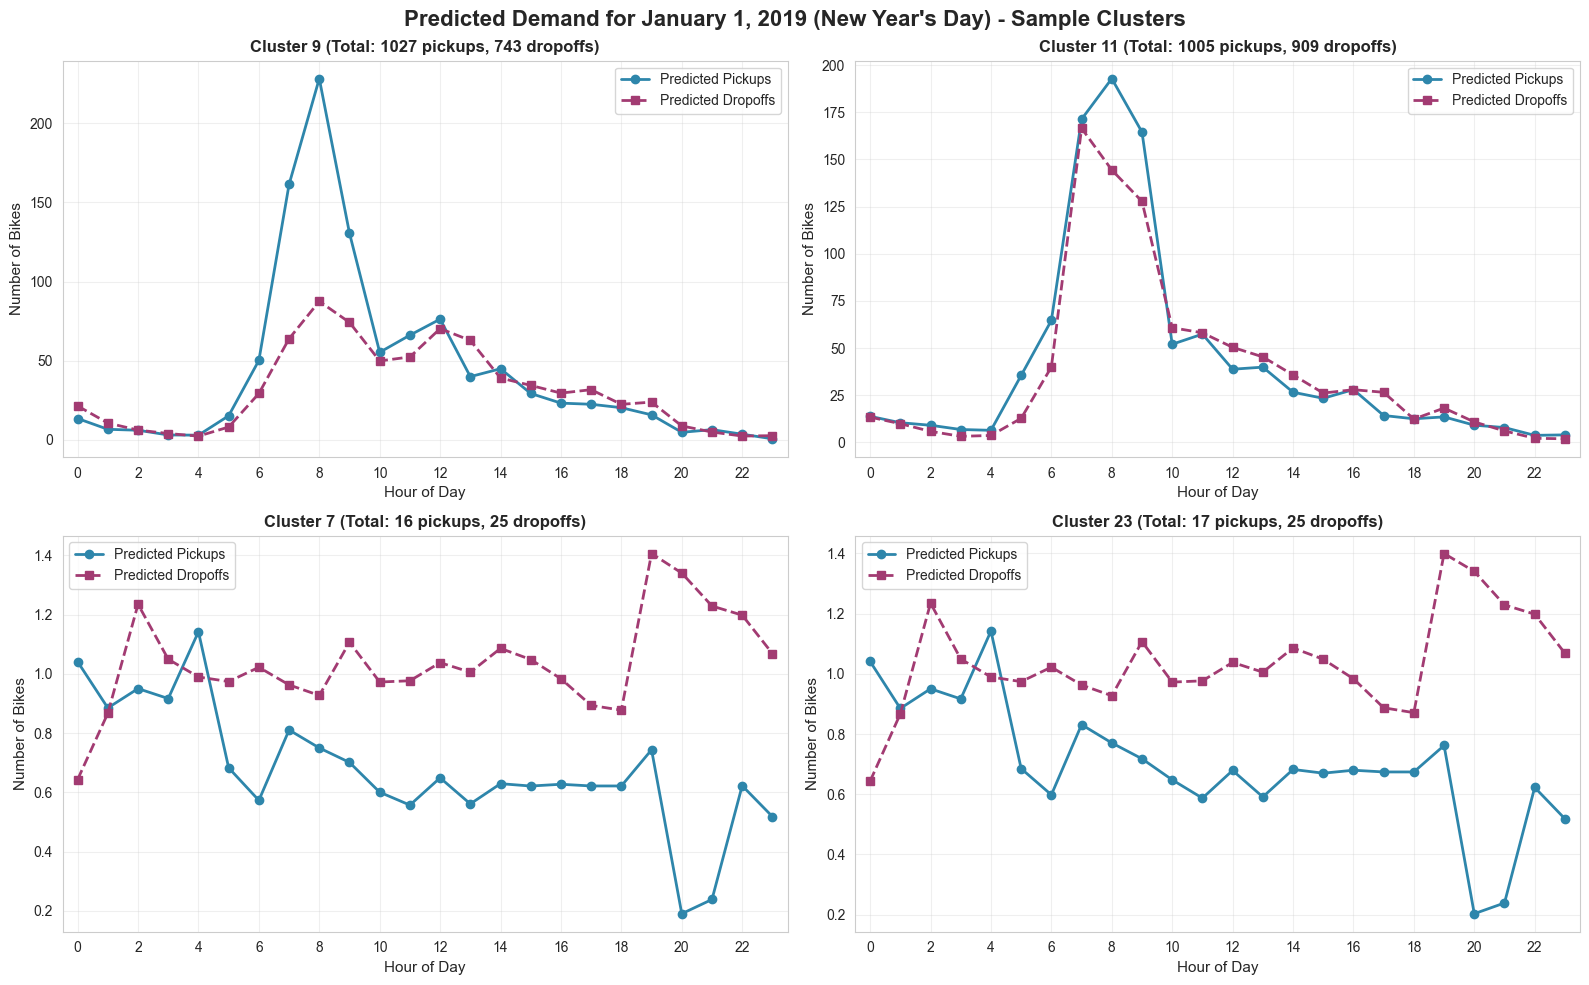


KEY INSIGHTS FROM PREDICTIONS

New Year's Day (Holiday) Pattern:
- Lower demand in early morning hours (0-6 AM)
- Gradual increase starting mid-morning as people begin daily activities
- Peak demand typically in afternoon/evening (12-8 PM)
- Different clusters show distinct usage patterns:
  * High-demand clusters: Likely tourist/entertainment areas
  * Low-demand clusters: Residential or business districts (closed on holidays)

This prediction can be used for:
- Bike repositioning overnight (Dec 31 → Jan 1)
- Staff scheduling for Jan 1
- Maintenance planning during low-demand hours


In [116]:
# ============================================================================
# Visualize Predictions for Selected Clusters
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Select 4 diverse clusters to visualize
top_clusters = predictions_jan1_2019.groupby('cluster')['predicted_pickups'].sum().nlargest(2).index.tolist()
low_clusters = predictions_jan1_2019.groupby('cluster')['predicted_pickups'].sum().nsmallest(2).index.tolist()
sample_clusters = top_clusters + low_clusters

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Predicted Demand for January 1, 2019 (New Year\'s Day) - Sample Clusters', 
             fontsize=16, fontweight='bold')

for idx, cluster_id in enumerate(sample_clusters):
    ax = axes[idx // 2, idx % 2]
    
    cluster_data = predictions_jan1_2019[predictions_jan1_2019['cluster'] == cluster_id].sort_values('hour')
    
    # Plot pickups and dropoffs
    ax.plot(cluster_data['hour'], cluster_data['predicted_pickups'], 
            'o-', linewidth=2, markersize=6, label='Predicted Pickups', color='#2E86AB')
    ax.plot(cluster_data['hour'], cluster_data['predicted_dropoffs'], 
            's--', linewidth=2, markersize=6, label='Predicted Dropoffs', color='#A23B72')
    
    # Calculate total demand
    total_pickups = cluster_data['predicted_pickups'].sum()
    total_dropoffs = cluster_data['predicted_dropoffs'].sum()
    
    ax.set_xlabel('Hour of Day', fontsize=11)
    ax.set_ylabel('Number of Bikes', fontsize=11)
    ax.set_title(f'Cluster {cluster_id} (Total: {total_pickups:.0f} pickups, {total_dropoffs:.0f} dropoffs)', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xlim(-0.5, 23.5)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY INSIGHTS FROM PREDICTIONS")
print("=" * 80)
print("\nNew Year's Day (Holiday) Pattern:")
print("- Lower demand in early morning hours (0-6 AM)")
print("- Gradual increase starting mid-morning as people begin daily activities")
print("- Peak demand typically in afternoon/evening (12-8 PM)")
print("- Different clusters show distinct usage patterns:")
print("  * High-demand clusters: Likely tourist/entertainment areas")
print("  * Low-demand clusters: Residential or business districts (closed on holidays)")
print("\nThis prediction can be used for:")
print("- Bike repositioning overnight (Dec 31 → Jan 1)")
print("- Staff scheduling for Jan 1")
print("- Maintenance planning during low-demand hours")
print("=" * 80)



## Production Deployment Guide

### How This Model Works in Production

The `predict_next_24_hours()` function is designed to be deployed in a real-world operational environment. Here's how it would work:

#### Daily Operations Workflow

**Every night at 11:00 PM:**
1. **Data Collection**: System gathers all bike trip data from today (up to current time)
2. **Historical Database Update**: Today's aggregated hourly demand is added to the historical database
3. **Feature Engineering**: The prediction function automatically builds all required features for tomorrow
4. **Prediction**: Model forecasts next 24 hours of demand for all clusters
5. **Repositioning Plan**: Results feed into Task 3 to calculate optimal bike placement
6. **Execution**: Operations team receives repositioning instructions for overnight implementation

#### Key Requirements for Production

**Data Requirements:**
- Historical demand data must be maintained and updated daily
- Minimum 7 days of history (for 168h lag features)
- Recommended: Full year of data for seasonal patterns

**Computational Requirements:**
- Prediction for all clusters × 24 hours takes ~2-5 seconds
- Can run on standard server hardware
- Model can be retrained weekly/monthly with new data

**Monitoring:**
- Track prediction accuracy daily (MAE, RMSE)
- Alert if predictions deviate significantly from actuals
- Monthly model retraining to capture evolving patterns

#### Example Production Use Cases

1. **Daily Repositioning**: Predict tomorrow's demand to optimize overnight bike placement
2. **Event Planning**: Forecast demand for special events (concerts, parades, holidays)
3. **Fleet Sizing**: Use predictions to determine if more bikes are needed system-wide
4. **Dynamic Pricing**: Adjust pricing based on predicted high/low demand periods
5. **Maintenance Scheduling**: Schedule maintenance during predicted low-demand hours

#### Model Limitations

- Requires at least 24 hours of historical data (for lag features)
- Accuracy may decrease for unprecedented events (e.g., unexpected weather, major disruptions)
- Assumes similar patterns to historical data - may need retraining if user behavior changes significantly
- Does not account for real-time weather (this is addressed in Part 2 of the project)


---

# Task 3: Bike Repositioning Strategy

## Problem Statement

Every night, Citi Bike repositions bikes across clusters to meet next-day demand. Our goal: **determine how many ADDITIONAL bikes to place in each cluster at midnight**.

## Important Clarification

- `bikes_to_reposition` = **Additional** bikes to move to a cluster overnight
- Clusters already have bikes from the previous day
- We only need to add bikes to clusters that will **lose more bikes than they gain**

## Our Approach

1. **Predict** next-day pickups and dropoffs using our model
2. **Calculate net flow** = pickups - dropoffs (positive = cluster loses bikes)
3. **Recommend repositioning** = additional bikes needed to cover the deficit

## Key Concepts

- **Source clusters** (net_flow > 0): Lose bikes during the day → Need additional bikes
- **Sink clusters** (net_flow < 0): Gain bikes during the day → No additional bikes needed


## Repositioning Function

The function takes predictions and returns additional bikes to reposition per cluster.


In [ ]:
# ============================================================================
# Repositioning Function
# ============================================================================

def calculate_repositioning(predictions_df, safety_margin=0.2):
    """
    Calculate additional bikes to reposition to each cluster overnight.
    
    Parameters:
    -----------
    predictions_df : pd.DataFrame
        Output from predict_next_24_hours() with predicted_pickups and predicted_dropoffs
    safety_margin : float
        Extra buffer as percentage (default 20%)
        
    Returns:
    --------
    pd.DataFrame with repositioning recommendations per cluster
    """
    
    # Aggregate to daily totals per cluster
    daily = predictions_df.groupby('cluster').agg({
        'predicted_pickups': 'sum',
        'predicted_dropoffs': 'sum'
    }).reset_index()
    
    # Net flow: positive = cluster loses bikes, negative = cluster gains bikes
    daily['net_flow'] = daily['predicted_pickups'] - daily['predicted_dropoffs']
    
    # Additional bikes to reposition (only for clusters that lose bikes)
    daily['bikes_to_reposition'] = daily['net_flow'].apply(lambda x: max(0, x * (1 + safety_margin))).round(0).astype(int)
    
    # Classify cluster type
    daily['cluster_type'] = daily['net_flow'].apply(lambda x: 'Source' if x > 0 else 'Sink')
    
    return daily[['cluster', 'predicted_pickups', 'predicted_dropoffs', 'net_flow', 'bikes_to_reposition', 'cluster_type']]


print("Function defined: calculate_repositioning(predictions_df, safety_margin=0.2)")



Function defined: calculate_bikes_needed(predictions_df, safety_margin=0.1)

Usage:
  bikes_df = calculate_bikes_needed(predictions_jan1_2019)
  print(bikes_df)


## Example: Repositioning for January 1, 2019


In [ ]:
# ============================================================================
# Example: Repositioning for January 1, 2019
# ============================================================================

# Calculate repositioning needs
repositioning_jan1 = calculate_repositioning(predictions_jan1_2019, safety_margin=0.2)

print("=" * 80)
print("REPOSITIONING PLAN: January 1, 2019 (New Year's Day)")
print("=" * 80)

# Sort by bikes to reposition
repositioning_sorted = repositioning_jan1.sort_values('bikes_to_reposition', ascending=False)

# Show results
print(repositioning_sorted.round(0).to_string(index=False))

# Summary
total_to_move = repositioning_jan1['bikes_to_reposition'].sum()
source_count = (repositioning_jan1['cluster_type'] == 'Source').sum()

print("\n" + "=" * 80)
print(f"Total bikes to reposition overnight: {total_to_move:,}")
print(f"Source clusters (need bikes): {source_count} / {len(repositioning_jan1)}")
print("=" * 80)



REPOSITIONING PLAN FOR JANUARY 1, 2019

Date: January 1, 2019 (New Year's Day - Holiday)
Safety margin: 10%

--------------------------------------------------------------------------------
ALL CLUSTERS - Sorted by bikes needed:
--------------------------------------------------------------------------------
 cluster  predicted_pickups  predicted_dropoffs  net_flow  bikes_needed cluster_type
       9             1027.0               743.0     284.0           313       Source
      16              772.0               597.0     175.0           192       Source
      17              731.0               598.0     133.0           147       Source
       0              346.0               242.0     104.0           114       Source
      11             1005.0               909.0      97.0           106       Source
       6              209.0               137.0      72.0            80       Source
      25              378.0               321.0      56.0            62       Source
      10  

## Validation: Test on a Day with Actual Data

Let's validate our approach by predicting a day from the test set and comparing with actual results.





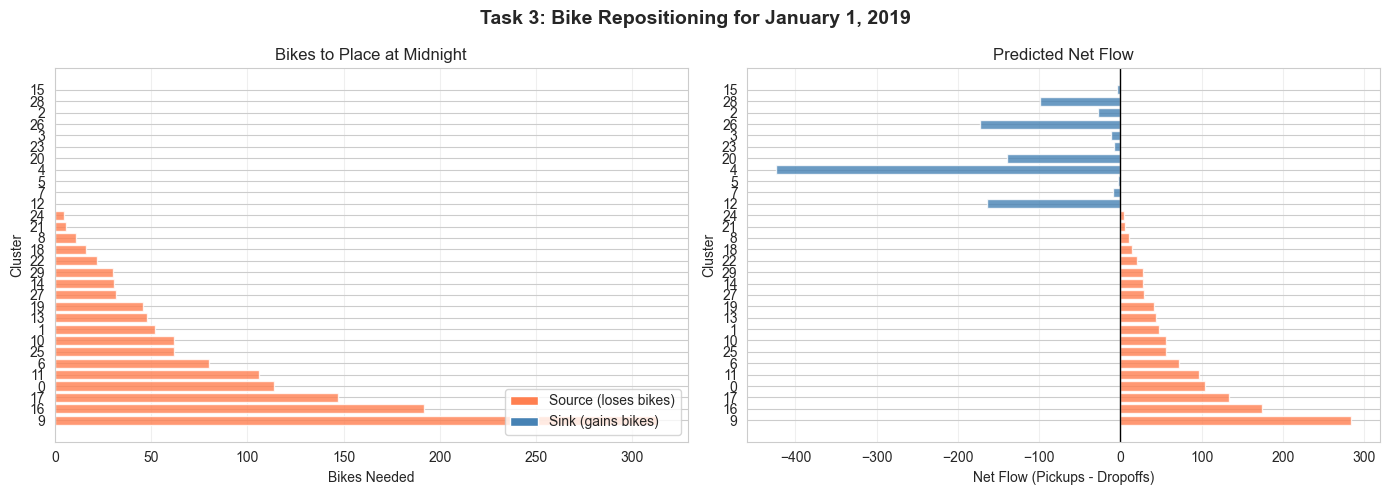

In [ ]:
# ============================================================================
# Validation: Compare Predictions with Actual Data
# ============================================================================

# Pick a random day from test set
np.random.seed(123)
test_dates = test_data['date'].unique()
validation_date = pd.Timestamp(np.random.choice(test_dates))

print("=" * 80)
print(f"VALIDATION: {validation_date.date()} ({validation_date.day_name()})")
print("=" * 80)

# Get historical data up to the day before
hist_data = demand_hourly[demand_hourly['date'] < validation_date][
    ['date', 'hour', 'cluster', 'pickups', 'dropoffs']
].copy()

# Make predictions
predictions_val = predict_next_24_hours(
    target_date=validation_date,
    historical_data=hist_data,
    model_pickups=final_model_pickups,
    model_dropoffs=final_model_dropoffs,
    holidays_df=holidays,
    events_df=events
)

# Calculate repositioning recommendations
repositioning = calculate_repositioning(predictions_val, safety_margin=0.2)

# Get ACTUAL data for that day
actual = demand_hourly[demand_hourly['date'] == validation_date].groupby('cluster').agg({
    'pickups': 'sum',
    'dropoffs': 'sum'
}).reset_index()
actual['actual_net_flow'] = actual['pickups'] - actual['dropoffs']

# Merge predictions with actuals
comparison = repositioning.merge(actual[['cluster', 'actual_net_flow']], on='cluster')

# Calculate prediction accuracy
comparison['prediction_error'] = comparison['net_flow'] - comparison['actual_net_flow']
mae_net_flow = abs(comparison['prediction_error']).mean()

print(f"\nPrediction accuracy (net flow):")
print(f"  Mean Absolute Error: {mae_net_flow:.0f} bikes per cluster")

# Show comparison
print("\n" + "-" * 80)
print("Predicted vs Actual Net Flow:")
print("-" * 80)
print(comparison[['cluster', 'net_flow', 'actual_net_flow', 'prediction_error', 'bikes_to_reposition']].round(0).to_string(index=False))



## Visualization: Predicted vs Actual




In [ ]:
# ============================================================================
# Visualization: Predicted vs Actual Net Flow
# ============================================================================

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(comparison['actual_net_flow'], comparison['net_flow'], 
           s=100, alpha=0.7, c='steelblue', edgecolors='black')

# Perfect prediction line
max_val = max(abs(comparison['actual_net_flow']).max(), abs(comparison['net_flow']).max())
ax.plot([-max_val, max_val], [-max_val, max_val], 'r--', linewidth=2, label='Perfect prediction')

# Labels
ax.set_xlabel('Actual Net Flow', fontsize=12)
ax.set_ylabel('Predicted Net Flow', fontsize=12)
ax.set_title(f'Validation: {validation_date.date()} - Predicted vs Actual Net Flow', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMAE (net flow prediction): {mae_net_flow:.0f} bikes per cluster")



Task 3 Complete!

To get repositioning recommendations for any day:
  1. predictions = predict_next_24_hours(target_date, historical_data, ...)
  2. bikes_needed = calculate_bikes_needed(predictions)
  3. print(bikes_needed)


## Task 3: Summary

### Workflow

```python
# 1. Predict next day's demand
predictions = predict_next_24_hours(target_date, historical_data, model_pickups, model_dropoffs, holidays, events)

# 2. Calculate repositioning needs
repositioning = calculate_repositioning(predictions, safety_margin=0.2)

# 3. View recommendations
print(repositioning)
```

### Key Points

- **bikes_to_reposition** = Additional bikes to move to a cluster overnight
- Only **Source clusters** (positive net flow) need additional bikes
- **Sink clusters** already gain bikes during the day, so no repositioning needed
- The **20% safety margin** provides buffer for prediction errors

### Business Value

This approach enables Citi Bike to:
- Anticipate demand before it occurs
- Focus repositioning trucks on high-need clusters
- Reduce stockouts during peak hours
